<h1>IS4242 Group Project</h1>

<b>Import necessary libraries</b>

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import SMOTE

<h5>Running the code</h5>
Ensure that you are in the root folder of all the fold folders and target files
read_text(fold_name):
    fold_name: this is the name of the fold you want to read ALL patient files of. It will be read into a 2 dimensional
    list. If you would like to retrieve just the first patient instead, you will need to change the line 
    "txt_all.extend(txt[1:])" to "txt_all.append(txt[1:])" and you will be to use "read_text(fold1.txt)[0]" to retrieve
    the relevant patient's data
read_ans(file_name):
    file_name: this is the name of the file you want to read ALL targets of. It will be read into a 2 dimensional
    list. To retrieve the first patient's target: read_ans(ans.csv)[0]
put_single_into_dataframe(txt): This functions takes in 2 dimensional list ie the output of read_text(fold1.txt) 
put_multiple_into_dataframe(txt): Multiple is for using it with the output of read_text after you wanted to change it to append


In [2]:
def read_text(fold_name):
    txt_all = list()
    for f in os.listdir(fold_name): # for each file in the directory
        if f.endswith(".txt"):
            with open(os.path.join(fold_name, f), 'r') as fp: # open each file
                txt = fp.readlines() # read inside the file
                recordid = txt[1].rstrip('\n').split(',')[-1] # get recordid
                txt = [[int(recordid)] + t.rstrip('\n').split(',') for t in txt] # preface each row with the recordid as all patients are 1 file
                txt_all.extend(txt[1:]) # skip the parameter list
    return txt_all

def read_one_text(fold_name):
    txt_all = list()
    for f in os.listdir(fold_name): # for each file in the directory
        if f.endswith(".txt"):
            with open(os.path.join(fold_name, f), 'r') as fp: # open each file
                txt = fp.readlines() # read inside the file
            recordid = txt[1].rstrip('\n').split(',')[-1] # get recordid
            txt = [[int(recordid)] + t.rstrip('\n').split(',') for t in txt] # preface each row with the recordid as all patients are 1 file
            txt_all.append(txt[1:]) # skip the parameter list
    return txt_all

def read_ans(file_name):
    txt_all = list()
    with open(file_name, 'r') as fp: # opens the csv file
        txt = fp.readlines() 
    for i in range(1, len(txt)): # similar to above read_text
        record_id, length_of_stay, hospital_death = txt[i].rstrip('\n').split(',')
        txt_all.append([record_id, length_of_stay, hospital_death])
    return txt_all

def put_multiple_into_dataframe(txt_all):
    df = pd.DataFrame()
    for i in txt_all:
        df2 = pd.DataFrame(i, columns=['recordid', 'time', 'parameter', 'value'])
        df = df.append(df2, ignore_index=True)
    return df

def put_single_into_dataframe(txt_all):
    df = pd.DataFrame(txt_all, columns=['recordid', 'time', 'parameter', 'value'])
    return df

def get_X_add_ready(X_add, stat):
    X_add = X_add.reset_index()
    X_add = X_add.pivot(index='recordid', columns='parameter', values='value')
    X_add = X_add.drop(stat_feat, axis = 1) 
#     X_add = X_add.drop(['RecordID'], axis = 1) 
    X_add.columns = [x+stat for x in X_add.columns]
    X_add = X_add.reset_index()
    return X_add

<h1>1. Data Exploration</h1>

Firstly, read_one_text function is used to read in the folder (eg. Fold1) containing the patient's individual record file. The index 0 in this case in the first line: p1 = read_one_text('../Project_Data/Fold1')[0] is to retrieve the first patient's record in the folder entered inside the function read_one_text. For example, to retrieve the last patient record in Fold3 folder, one has to type: p1 = read_one_text('../Project_Data/Fold3')[999]

Format to get individual record: p1 = read_one_text('../Project_Data/x')[y]

x = folder of the patient to retrieve

y = index row of the patient inside the folder - 1

Next, this patient record will then undergo preprocessing steps as follows to remove unnecessary information and transform the data into a more meaningful one. This patient record is transformed into dataframe with the columns 'recordid', 'time', 'parameter', 'value'. The recordid of this patient is stored in a variable called 'recordId' before dropping both the column 'recordid' and the first row in the dataframe which contains the recordid of this patient as they are now redundant. 

Subsequently, data in the column for 'value' is converted to numeric so as to facilitate the plotting of graph later. A new column called 'time_value' is created to store a tuple of 'time' and 'value'. The dataframe is then grouped by the 'parameter' column and then the 'time_value' tuple is then stored in a list based on the parameter. 

Finally, the groupby object is then plotted into a graph with each unique parameter as a different line in the graph with the x-axis in hours and y-axis as the values which the parameter is measured.

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


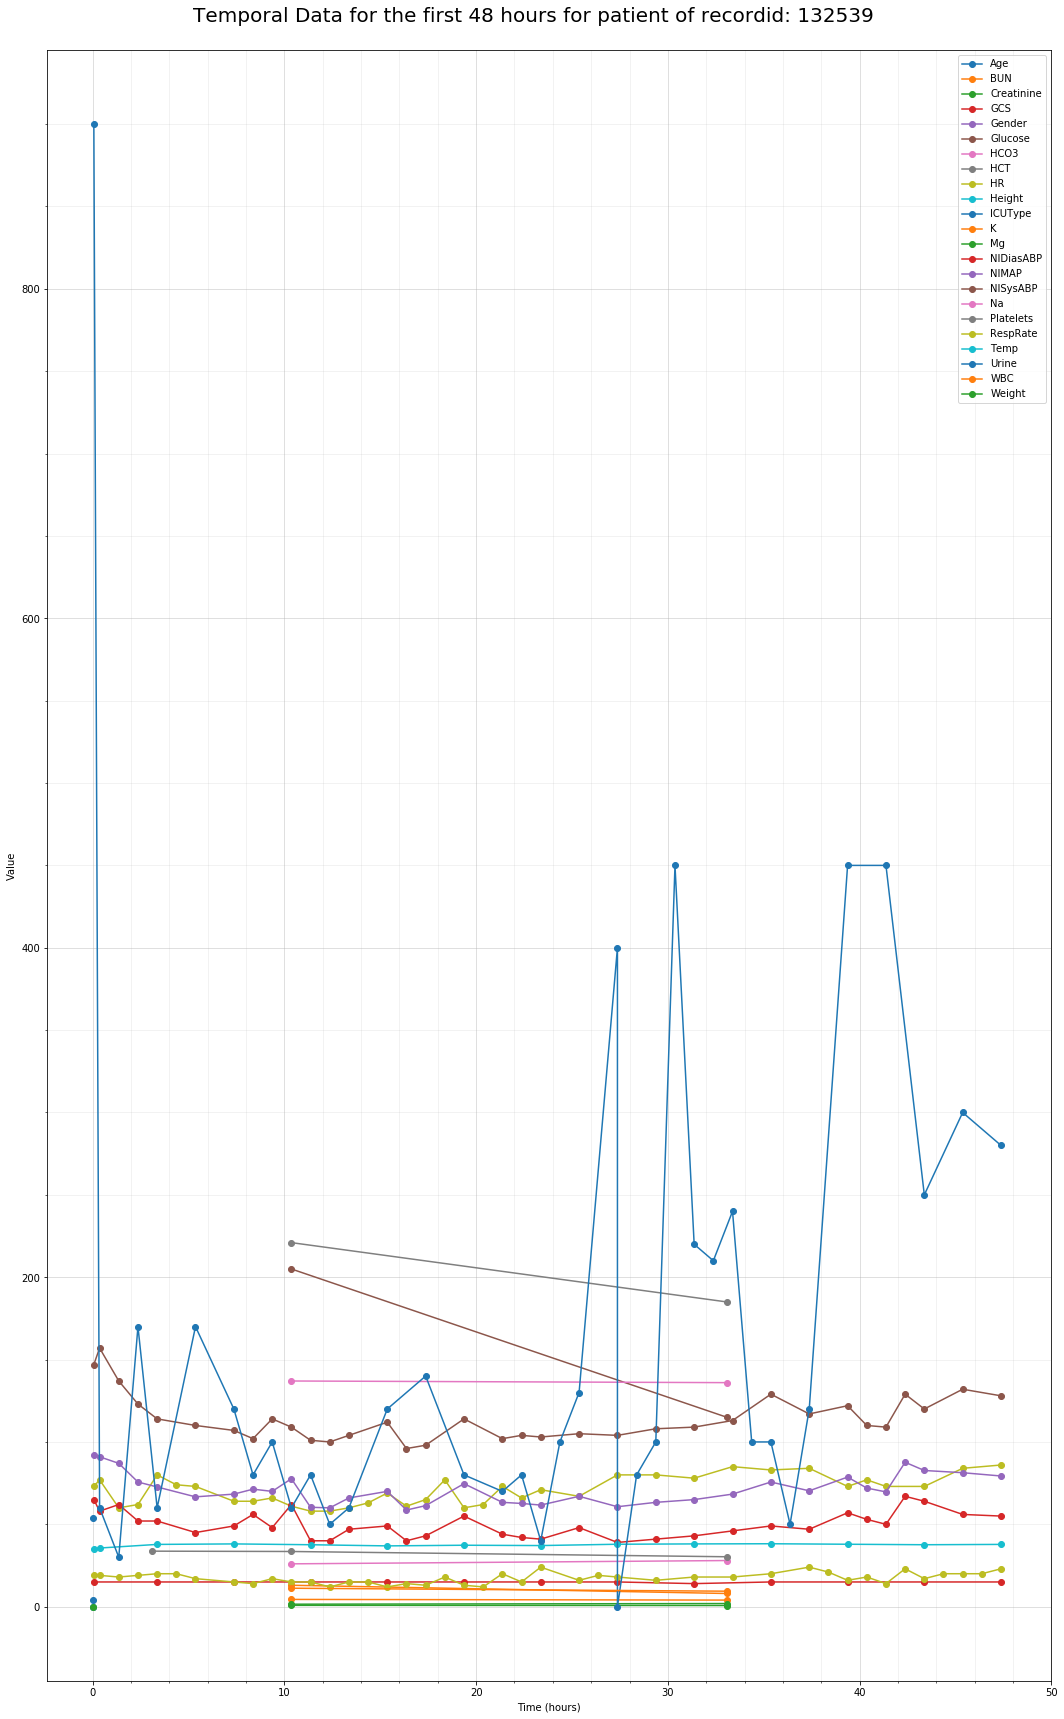

In [3]:
p1 = read_one_text("../Project_Data/Fold1")[0]
p1df = pd.DataFrame(p1, columns=['recordid', 'time', 'parameter', 'value'])
recordId = p1df.iloc[0]['value']
df_1 = p1df.drop('recordid', axis=1)
df_1.drop(df_1.index[:1], inplace=True)
# df_1

df_1['value'] = pd.to_numeric(df_1['value'])
df_1.time = df_1.time.astype('str')
df_1['time'] = df_1['time'].str.replace(':', '.')
df_1['time'] = pd.to_numeric(df_1['time'])
df_1['value'][df_1['value'] < 0] = 0
df_1['time_value'] = list(zip(df_1.time, df_1.value))
df_2 = df_1.groupby('parameter').time_value.apply(lambda x: x.unique().tolist())

major_ticks = np.arange(0, 51, 10)
minor_ticks = np.arange(0, 49, 2)
fig = plt.figure(figsize=(18, 30))
ax = fig.add_subplot(1, 1, 1)
for i in range(len(df_2)):
    testList2 = [(elem1, elem2) for elem1, elem2 in df_2[i]]
    zip(*testList2)
    plt.plot(*zip(*testList2), marker='o', label=df_2.index[i])
plt.xlabel('Time (hours)')
plt.ylabel('Value')
plt.legend(loc='upper right')
title = 'Temporal Data for the first 48 hours for patient of recordid: ' + recordId
fig.suptitle(title, fontsize=20, y=0.9)
# plt.xlim(xmin=0.0)
# plt.ylim(ymin=0.0)
ax.minorticks_on()
ax.set_xticks(minor_ticks, minor=True)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
# ax.tick_params(which = 'both', direction = 'out')
plt.show()

In [4]:
df_feat = pd.DataFrame()
numberOfFolds = 0
for i, name in enumerate(["Fold1"]): # what folds do you want to use?
    string = "../Project_Data/"
    string += name
    df_feat = df_feat.append(put_single_into_dataframe(read_text(string)))
    numberOfFolds = (i+1)
numberOfRows = numberOfFolds*1000
df_feat.head()

,recordid,time,parameter,value
0,132539,00:00,RecordID,132539
1,132539,00:00,Age,54
2,132539,00:00,Gender,0
3,132539,00:00,Height,-1
4,132539,00:00,ICUType,4


In [5]:
# Reading Target
df_target = pd.DataFrame(read_ans('../Project_Data/Fold1_Outcomes.csv'), columns=['recordid', 'days_in_hospital', 'mortality'])
df_target.head()

,recordid,days_in_hospital,mortality
0,132539,5,0
1,132540,8,0
2,132541,19,0
3,132543,9,0
4,132545,4,0


In [6]:

bin_feat = ['MechVent']
num_feat = ['Albumin', 'ALP', 'ALT', 'AST', 'Bilirubin', 'BUN', 'Cholesterol',
           'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Glucose', 'HCO3', 'HCT',
           'HR', 'K', 'Lactate', 'Mg', 'MAP', 'NA', 'NIDiasABP', 'NIMAP',
           'NISysABP', 'PaCO2', 'PaO2', 'pH', 'Platelets', 'RespRate', 'SaO2',
           'SysABP', 'Temp', 'Tropl', 'TropT', 'Urine', 'WBC', 'Weight']

print("Number of record ids:", len(df_feat['recordid'].unique()))
unique_count = df_feat['parameter'].value_counts()/numberOfRows
print(unique_count)

Number of record ids: 1000
HR             57.027
MAP            36.092
SysABP         35.979
DiasABP        35.955
Urine          34.208
Weight         33.679
NISysABP       24.457
NIDiasABP      24.424
NIMAP          24.088
Temp           21.204
GCS            15.214
RespRate       13.775
FiO2            7.815
MechVent        7.596
pH              5.770
PaO2            5.496
PaCO2           5.490
HCT             4.626
K               3.708
Creatinine      3.573
Platelets       3.566
BUN             3.547
HCO3            3.479
Mg              3.468
Na              3.462
Glucose         3.338
WBC             3.286
SaO2            1.985
Lactate         1.924
ICUType         1.000
Age             1.000
Gender          1.000
Height          1.000
RecordID        1.000
Bilirubin       0.858
AST             0.857
ALT             0.857
ALP             0.833
Albumin         0.617
TroponinT       0.566
TroponinI       0.130
Cholesterol     0.077
Name: parameter, dtype: float64


<h2>Analysis of Features</h2>
<p>The data above shows the average number of times a variable observed per patient. Based on the data above and the feature description we classify the features into these categories:
<ul>
    <li>General Descriptors (static data) that are collected when the patient is admitted to the ICU. Weight is not included as weight are measured multiple times as a time series data. Each of the descriptors will be included as a feature into the model.</li>
    <li>Rare features: measured on average less than one time per patient (less than 1.0). We use the <u>existence</u> of these measurements for each patient as a feature.</li>
    <li>Features that measured often or more that one time per patient (more than 1.0). Calculate the hourly average of each measurements and put them into 48 columns. <i>Example, average HR on the first hour to HR_1, average HR on the second hour to HR_2, and so on.</i></li>
</ul>
</p>


In [7]:
stat_feat = ['Age', 'Gender', 'Height', 'ICUType', 'RecordID'] #General Descriptors
rare_feat = []
nor_feat = []
for index, value in unique_count.items():
    if value < 1.0:
        rare_feat.append(index)
    elif index not in stat_feat:
        nor_feat.append(index)
rare_feat.append("MechVent")
print("Rare features", rare_feat)
print("Normal features", nor_feat)

Rare features ['Bilirubin', 'AST', 'ALT', 'ALP', 'Albumin', 'TroponinT', 'TroponinI', 'Cholesterol', 'MechVent']
Normal features ['HR', 'MAP', 'SysABP', 'DiasABP', 'Urine', 'Weight', 'NISysABP', 'NIDiasABP', 'NIMAP', 'Temp', 'GCS', 'RespRate', 'FiO2', 'MechVent', 'pH', 'PaO2', 'PaCO2', 'HCT', 'K', 'Creatinine', 'Platelets', 'BUN', 'HCO3', 'Mg', 'Na', 'Glucose', 'WBC', 'SaO2', 'Lactate']


In [8]:
# your code to produce test and train data
df = df_feat.copy()

<h2>Creation of Data Matrices</h2>
<p>We create 3 different matrices to convert temporal data into a matrix that is a single feature vector per patient.</p>
<h3>First Design Matrix</h3>
<ul> 
    <li>In the cell below, we create a matrix that generalises a patient's attributes across the whole 48 hours, such as his max BUN measurement over the 48 hours. This is so as to create a much denser feature matrix as well as provide a much clearer signal to the learner, allowing it to generalise to data outside of the train set.</li>
    <li>We will be utilising the min, max and mean of the measurements</li>
    <li>We have converted sparse features like ALS into a binary variable where 1 represents "It was recored" and 0 representing "It was not recorded at all".</li>
    <li>ICUType was one-hot encoded</li>
</ul>

In [9]:
def preprocess_x_for_design_matrix_1(df_feat):
    non_bin_feat.clear()
    # your code to produce test and train data
    df = df_feat.copy()

    df['value'] = pd.to_numeric(df['value'])
    temp_df = df.loc[df['time'] == '00:00', :].copy() # get all the variables at time 0
    temp_df = temp_df.loc[temp_df['parameter'].isin(stat_feat)] # prune the dataframe to only those static variables
    temp_df = temp_df.pivot(index='recordid', columns='parameter', values='value') 
    temp_df = temp_df.reset_index()
    for i in temp_df: # for loop to change all the -1 values for static variables into np.nan
        idx = temp_df.index[temp_df[i] == -1].tolist()
        for j in idx:
            temp_df.loc[j, i] = np.nan
    final_df = temp_df.copy()

#     Dealing with rare_feat
    d = df_feat.groupby(['recordid', 'parameter'])[['value']].count()
    def specialFeature(special):
        id = []
        for index, row in d.iterrows():
            if index[1] == special:
                id.append(index[0])
        return id
    for x in rare_feat:
        id = specialFeature(x)
        final_df[x] = 0
        for i in id:
            for row in final_df.index:
                if row == i:
                    final_df.loc[row, x] = 1
    final_df = final_df.drop(["RecordID"],axis=1)

    # Getting the different attributes
    pd.set_option('display.max_columns', 500)
    temp_df = df.drop(df.index[df['parameter'].isin(rare_feat)].tolist())
    temp_df = temp_df.groupby(['recordid', 'parameter'])[['value']]
    for i in ['min', 'max', 'mean']: # the different parameters we will use
        if (i=='min'):
            X_add = temp_df.min() # get the min of each parameter
            X_add = get_X_add_ready(X_add, '_min')
            final_df = final_df.merge(X_add, left_on='recordid', right_on='recordid') # merge the min of the parameters to the final dataframe
        elif (i=='max'):
            X_add = temp_df.max() # get the max of each parameter
            X_add = get_X_add_ready(X_add, '_max')
            final_df = final_df.merge(X_add, left_on='recordid', right_on='recordid') # merge the min of the parameters to the final dataframe
        elif (i=='mean'):
            X_add = temp_df.mean() # get the mean of each parameter
            X_add = get_X_add_ready(X_add, '_mean')
            final_df = final_df.merge(X_add, left_on='recordid', right_on='recordid') # merge the min of the parameters to the final dataframe

    # dealing with ICUType categorical
    one_hot = pd.get_dummies(final_df['ICUType'])
    meaning_of_icu_types = {1:'Coronary Care Unit', 2: 'Cardiac Surgery Recovery Unit', 3: 'Medical ICU', 4: 'Surgical ICU'}
    one_hot.columns = [meaning_of_icu_types[x] for x in one_hot.columns]
    final_df = final_df.merge(one_hot, left_index=True, right_index=True)
    final_df = final_df.drop('ICUType', axis=1)
    
    # Extreme height values is set to np.nan
    for index, row in final_df.iterrows():
        if row["Height"] < 40 or row["Height"] > 210:
            row["Height"] = np.nan


    # Drop recordID column
    final_df = final_df.drop("recordid", axis=1)
            
    # Creating non binary column list and filling na values with mean
    for i in final_df:
        if i in rare_feat or i in bin_feat:
            continue
        final_df = final_df.fillna(final_df.mean())
        non_bin_feat.append(i)
        
#     display(final_df.head())
    return final_df

<h3>Second Design Matrix</h3>
<ul> 
    <li>The second design matrix is created in such a way that every parameters is grouped into a 12-hour bin (eg. 0-12, 12-24, 24-36, 36-48). If a parameter is measured multiple times within a 12-hour bin, a mean of those measurement will be recorded to represent the measurement for that 12-hour bin instead. The assumption for using the mean for 12-hour is that once patients are sent to the ICU, they must be closely monitored and furthermore, the working shift of nurses in hospital is usually by 12-hour and so this ensures lesser human errors when the nurses change shift and patient is being measured.</li>
        <li>We have converted sparse features like ALS into a binary variable where 1 represents "It was recored" and 0 representing "It was not recorded at all".</li>
    <li>ICUType was one-hot encoded</li>
</ul>

In [10]:
# Second Matrix
def preprocess_x_for_design_matrix_2(df):
    non_bin_feat.clear()
    
    # retrieving static data of the patients at time 0 and transformed into dataframe with static feature as the column 
    # headers and each row in the dataframe representing each patient record, which is indexed by their record id
    df_static = df.loc[df['time'] == '00:00', :].copy()
    static_vars = ['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight']
    df_static.drop('time', axis=1, inplace=True)
    df_static = df_static.loc[df_static['parameter'].isin(static_vars)]
    df_static = df_static.groupby(['recordid', 'parameter'])[['value']].last()
    df_static.reset_index(inplace=True)
    df_static = df_static.pivot(index='recordid', columns='parameter', values='value')

    for c in df_static.columns:
        df_static[c] = pd.to_numeric(df_static[c])

    # replacing height and weight which does not exist (represented with '-1') with NaN
    for c in df_static.columns:
        x = df_static[c]
        if c == 'Height':
            idx = x < 0
            df_static.loc[idx, c] = np.nan
        elif c == 'Weight':
            idx = x < 0
            df_static.loc[idx, c] = np.nan
    d = df.groupby(['recordid', 'parameter'])[['value']].count()
    def specialFeature(special):
        id = []
        for index, row in d.iterrows():
            if index[1] == special:
                id.append(index[0])
        return id

    # RecordID column is dropped as every row is already indexed by the recordid
    df2 = df_static.copy()
    df2.drop('RecordID', axis=1, inplace=True)

    # rare features which are rarely measured such as Cholesterol are converted to binary features which indicates whether 
    # any measurement for these variables were recorded within the first 48 hours. Binary feature was also created for 
    # MechVent to indicate whether the patient was placed on mechanical ventilation
    for x in rare_feat:
        id = specialFeature(x)
        df2[x] = 0
        for i in id:
            for row in df2.index:
                if row == i:
                    df2.loc[row, x] = 1
    df2.head()
    normal_feat = nor_feat.copy()
    normal_feat.remove('MechVent')
    
    # grouped the rest of the parameters into 12-hour bins and the mean of the parameter in a given 12-hour interval
    # is taken if it was measured more than once during that 12-hour interval
    idx = df['parameter'].isin(normal_feat)
    df3 = df.loc[idx, :].copy()
    df3[['hour','min']] = df3.time.str.split(':', expand=True)
    df3["hour"] = pd.to_numeric(df3["hour"])
    df3["value"] = pd.to_numeric(df3["value"])
    bins = [0, 12, 24, 36, 48]
    labels = ['0', '12', '24', '36']
    
    # grouped by recordid first, then by each 12-hour interval then by the parameters
    df3 = df3.groupby(['recordid', pd.cut(df3.hour, bins=bins, labels=labels), 'parameter'])[['value']].mean()
    df3

    # filled in the dataframe with NaN first
    for n in normal_feat:    
        df2[n +'0'] = np.nan
        df2[n +'12'] = np.nan
        df2[n +'24'] = np.nan
        df2[n +'36'] = np.nan
    df2.head()

    # go through every row in groupby table and insert these values into the dataframe with NaN, replacing them
    for index, row in df3.iterrows():
        recordId = index[0]
        hour = index[1]
        parameter = index[2]
        df2.loc[recordId, parameter+hour] = row["value"]

    one_hot = pd.get_dummies(df2['ICUType'])
    meaning_of_icu_types = {1:'Coronary Care Unit', 2: 'Cardiac Surgery Recovery Unit', 3: 'Medical ICU', 4: 'Surgical ICU'}
    one_hot.columns = [meaning_of_icu_types[x] for x in one_hot.columns]
    df2 = df2.merge(one_hot, left_index=True, right_index=True)
    df2 = df2.drop('ICUType', axis=1)
    
    # Extreme height values is set to np.nan
    for index, row in df2.iterrows():
        if row["Height"] < 40 or row["Height"] > 210:
            row["Height"] = np.nan
            
    # Creating non binary column list and filling na values with mean
    for i in df2:
        if i in rare_feat or i in bin_feat:
            continue
        df2 = df2.fillna(df2.mean())
        non_bin_feat.append(i)

    display(df2.head())
    return df2

<h3>Third Design Matrix</h3>
<p>This design matrix splits all numerical time series data into hourly bins. The average value of the measurements on each hour will be taken and put into the columns. The idea of this is to get the condition of the patient on each hour from coming in to the hospital until the 48 hour mark. All rare features will be taken as a binary feature of whether the measurement appear within 48 hours. All general descriptors taken as it is except weight.</p>

In [11]:
def preprocess_x_for_design_matrix_3(df_feat):
    df = pd.DataFrame()
    
    tot_values = {} # the sum of the values
    count = {} # num of occurences of a measurement
    for index,row in df_feat.iterrows():
        if row['parameter'] == 'RecordID' and index != 0:
            # count the average of the previous record
            for key,value in tot_values.items():
                tot_values[key] = float(tot_values[key])/count[key]

            df = df.append(tot_values, ignore_index=True)
            tot_values.clear()
            count.clear()
            for feat in rare_feat:
                tot_values[feat] = 0;
                count[feat] = 1;

        if row['parameter'] in stat_feat:
            tot_values[row['parameter']] = row['value']
            count[row['parameter']] = 1
        elif row['parameter'] in rare_feat:
            tot_values[row['parameter']] = 1
            count[row['parameter']] = 1
        elif row['parameter'] in nor_feat and row['parameter'] != 'MechVent':
            hour = int(row['time'][0:2]) + 1
            if hour == 49: hour-=1
            col = row['parameter'] + '_' + str(hour)
            tot_values[col] = row['value']
            if col in count:
                count[col] = count[col] + 1
            else:
                count[col] = 1

    # count the average of the previous record
    for key,value in tot_values.items():
        tot_values[key] = float(tot_values[key])/count[key]

    df = df.append(tot_values, ignore_index=True)
    
    df = df.astype({'RecordID': 'int32', 'ICUType':'int32'})
    
    return df

<h1>Model Building for M1</h1>
<p>We develop models for our design matrix.</p>


In [12]:
# preprocess y dataframe for use in linear regression
def preprocess_y_linear(temp_df):
    temp_df = temp_df.drop(['recordid','mortality'], axis=1)
    temp_df['days_in_hospital'] = pd.to_numeric(temp_df['days_in_hospital'])
    for index, row in temp_df.iterrows():
        if row['days_in_hospital'] == -1:
            row['days_in_hospital'] = 2   
    return temp_df

# preprocess y dataframe for use in classification
def preprocess_y_class(temp_df):
    temp_df = temp_df.drop(['recordid','days_in_hospital'], axis=1)
    temp_df['mortality'] = pd.to_numeric(temp_df['mortality'])  
    return temp_df

bin_feat = ["Gender", "Coronary Care Unit", "Cardiac Surgery Recovery Unit", "Medical ICU", "Surgical ICU"]
non_bin_feat = []
scaler = ColumnTransformer(
    remainder = 'passthrough',
    transformers=[
        ('num', StandardScaler(), non_bin_feat)])
all_list = [1,2,3,4]

<h3>First Model</h3>
<ul> 
    <li>First, in the cell below, we make use of the first design matrix above to pass in as input to the models. It mannually does cross validation, where training is done on 3 folds and a test I.E. validation on the remaining fold. Included is 3 regresssion models (Linear, DecisionTree, MLP) and 3 classification models (AdaboostedDecisionTrees, MLP, GaussianNB). Each utilises their own pipelines which makes use diffrent feature selectors </li>
    <li></li>
</ul>

In [13]:
# Creating an array containing the preprocessed folds
folds_x = {}
folds_y_linear = {}
folds_y_class = {}
for i in all_list:
    x_string = "../Project_Data/Fold"+str(i)
    y_string = "../Project_Data/Fold"+str(i)+"_Outcomes.csv"
    temp_df_y = pd.DataFrame(read_ans(y_string), columns=['recordid', 'days_in_hospital', 'mortality'])
    temp_df_x = put_single_into_dataframe(read_text(x_string))
    folds_x[i] = preprocess_x_for_design_matrix_1(temp_df_x)
    folds_y_linear[i] = preprocess_y_linear(temp_df_y)
    folds_y_class[i] = preprocess_y_class(temp_df_y)

In [14]:
# Running CV

#Create a matrix to store the results where row represnets the model and column represents the result tested on fold i
w, h = 4, 5
matrix = [[0 for x in range(w)] for y in range(h)] 
matrix_class = [[0 for x in range(w)] for y in range(h)] 

# keep track of the best score when trying out different hyperparameters in a fold
best = sys.maxsize
param = ""

all_list = [1,2,3,4]
for i in range(1,5):
    print("Testing on Fold", i)
    x_train_df = pd.DataFrame()
    y_train_linear_df = pd.DataFrame()
    y_train_class_df = pd.DataFrame()
    x_test_df = pd.DataFrame()
    y_test_linear_df = pd.DataFrame()
    y_test_class_df = pd.DataFrame()

    # Getting train data set up
    print("# Getting train data set up")
    for j in [x for x in all_list if x != i]:
        x_train_df = x_train_df.append(folds_x[j])
        y_train_linear_df = y_train_linear_df.append(folds_y_linear[j])
        y_train_class_df = y_train_class_df.append(folds_y_class[j])

    # Getting test data set up 
    print("# Getting test data set up")
    x_test_df = folds_x[i]
    y_test_linear_df= folds_y_linear[i]
    y_test_class_df = folds_y_class[i]

    # Linear
    best = sys.maxsize
    parameters = {'f_selecter__threshold':[0.5,0.6], 
                  'dim_reducer__n_components':[60,70]}
    est = Pipeline(steps=[
            ('scaler', scaler),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', LinearRegression())])
    estimator = GridSearchCV(est, parameters, cv=3, scoring='neg_mean_squared_error')
    estimator.fit(x_train_df, y_train_linear_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix[i-1][0] = (mean_squared_error(y_test_linear_df, prediction))
    
    
    # DecisionTreeRegressor
    best = sys.maxsize
    parameters = {'f_selecter__threshold':[0.5], 
                  'dim_reducer__n_components':[60],
                  'classifier__min_samples_leaf':[3]
                 }
    est = Pipeline(steps=[
            ('scaler', scaler),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', DecisionTreeRegressor())])
    estimator = GridSearchCV(est, parameters, cv=3, scoring='neg_mean_squared_error')
    estimator.fit(x_train_df, y_train_linear_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix[i-1][1] = (mean_squared_error(y_test_linear_df, prediction))
    
    
    # MLPRegressor
    best = sys.maxsize
    parameters = {'f_selecter__threshold':[0.5,0.6], 
                  'dim_reducer__n_components':[60,70],
                  'classifier__hidden_layer_sizes':[(130, 110, 90, 70, 50, 30, 10, 5)],
                  'classifier__learning_rate_init':[0.105]
                 }
    est = Pipeline(steps=[
            ('scaler', scaler),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', MLPRegressor(max_iter=700))])
    estimator = GridSearchCV(est, parameters, cv=3, scoring='neg_mean_squared_error')
    estimator.fit(x_train_df, y_train_linear_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix[i-1][2] = (mean_squared_error(y_test_linear_df, prediction))
    
    # KNeighbours
    best = sys.maxsize
    parameters = {'f_selecter__threshold':[0.5], 
                  'dim_reducer__n_components':[60],
                  'classifier__n_neighbors':[3,2]
                 }
    est = imPipeline(steps=[
            ('scaler', scaler),
            ('smote', SMOTE()),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', KNeighborsClassifier())])
    estimator = GridSearchCV(est, parameters, cv=3, scoring='roc_auc')
    estimator.fit(x_train_df, y_train_class_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix_class[i-1][0] = (roc_auc_score(y_test_class_df, prediction))
    
    # Logistic Regression
    best = sys.maxsize
    parameters = {'f_selecter__threshold':[0.5], 
                  'dim_reducer__n_components':[60]
                 }
    est = imPipeline(steps=[
            ('scaler', scaler),
            ('smote', SMOTE()),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', LogisticRegression())])
    estimator = GridSearchCV(est, parameters, cv=3)
    estimator.fit(x_train_df, y_train_class_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix_class[i-1][1] = (roc_auc_score(y_test_class_df, prediction))
    
    # RandomForestClassifier
    best = sys.maxsize
    parameters = {'f_selecter__threshold':[0.5], 
                  'dim_reducer__n_components':[60],
                  'classifier__n_estimators':[10,15]
                 }
    est = imPipeline(steps=[
            ('scaler', scaler),
            ('smote', SMOTE()),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', RandomForestClassifier())])
    estimator = GridSearchCV(est, parameters, cv=3)
    estimator.fit(x_train_df, y_train_class_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix_class[i-1][2] = (roc_auc_score(y_test_class_df, prediction))

Testing on Fold 1
# Getting train data set up
# Getting test data set up


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was pass

C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

Testing on Fold 2
# Getting train data set up
# Getting test data set up


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was pass

C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

Testing on Fold 3
# Getting train data set up
# Getting test data set up


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was pass

C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

Testing on Fold 4
# Getting train data set up
# Getting test data set up


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was pass

C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

In [15]:
number_of_learners = 3
score_df = pd.DataFrame(matrix, columns=["Linear", "DecisionTree", "MLPRegressor",""])
score_class_df = pd.DataFrame(matrix_class, columns=["KNeighbour", "Logistic", "RandomForests",""])
for i in range(number_of_learners):
    score_df.iloc[4,i] = np.sqrt(score_df.iloc[0:3,i].mean())
    score_class_df.iloc[4,i] = score_class_df.iloc[0:3,i].mean()
display(score_df)
display(score_class_df)

,Linear,DecisionTree,MLPRegressor,
0,182.350825,284.935907,329.567204,0
1,127.902944,252.593032,137.467399,0
2,130.180134,263.532803,140.306301,0
3,253.797560,257.373306,119.254477,0
4,12.116571,16.340764,14.228386,0


,KNeighbour,Logistic,RandomForests,
0,0.680419,0.685798,0.547147,0
1,0.691552,0.717247,0.573040,0
2,0.651811,0.720945,0.576546,0
3,0.643528,0.675996,0.586690,0
4,0.674594,0.707997,0.565577,0


<h3>Second Model</h3>
<ul> 
    <li>We make use of the second Design matrix described above on the same parameters that we tried in the Model building 1.</li>
</ul>

In [16]:
# Creating an array containing the preprocessed folds
folds_x = {}
folds_y_linear = {}
folds_y_class = {}
for i in all_list:
    x_string = "../Project_Data/Fold"+str(i)
    y_string = "../Project_Data/Fold"+str(i)+"_Outcomes.csv"
    temp_df_y = pd.DataFrame(read_ans(y_string), columns=['recordid', 'days_in_hospital', 'mortality'])
    temp_df_x = put_single_into_dataframe(read_text(x_string))
    folds_x[i] = preprocess_x_for_design_matrix_2(temp_df_x)
    folds_y_linear[i] = preprocess_y_linear(temp_df_y)
    folds_y_class[i] = preprocess_y_class(temp_df_y)

,Age,Gender,Height,Weight,Bilirubin,AST,ALT,ALP,Albumin,TroponinT,TroponinI,Cholesterol,MechVent,HR0,HR12,HR24,HR36,MAP0,MAP12,MAP24,MAP36,SysABP0,SysABP12,SysABP24,SysABP36,DiasABP0,DiasABP12,DiasABP24,DiasABP36,Urine0,Urine12,Urine24,Urine36,Weight0,Weight12,Weight24,Weight36,NISysABP0,NISysABP12,NISysABP24,NISysABP36,NIDiasABP0,NIDiasABP12,NIDiasABP24,NIDiasABP36,NIMAP0,NIMAP12,NIMAP24,NIMAP36,Temp0,Temp12,Temp24,Temp36,GCS0,GCS12,GCS24,GCS36,RespRate0,RespRate12,RespRate24,RespRate36,FiO20,FiO212,FiO224,FiO236,pH0,pH12,pH24,pH36,PaO20,PaO212,PaO224,PaO236,PaCO20,PaCO212,PaCO224,PaCO236,HCT0,HCT12,HCT24,HCT36,K0,K12,K24,K36,Creatinine0,Creatinine12,Creatinine24,Creatinine36,Platelets0,Platelets12,Platelets24,Platelets36,BUN0,BUN12,BUN24,BUN36,HCO30,HCO312,HCO324,HCO336,Mg0,Mg12,Mg24,Mg36,Na0,Na12,Na24,Na36,Glucose0,Glucose12,Glucose24,Glucose36,WBC0,WBC12,WBC24,WBC36,SaO20,SaO212,SaO224,SaO236,Lactate0,Lactate12,Lactate24,Lactate36,Coronary Care Unit,Cardiac Surgery Recovery Unit,Medical ICU,Surgical ICU
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
132539,54,0,170.094476,81.422068,0,0,0,0,0,0,0,0,0,65.454545,66.090909,78.833333,78.571429,80.711313,79.358527,80.922914,81.500853,115.156032,118.234776,120.376778,121.372441,58.554776,58.822952,59.476010,59.876609,92.000000,86.250000,173.333333,308.333333,82.648197,83.383737,83.651991,83.759171,111.700000,104.125000,111.333333,120.875000,50.600000,45.125000,44.333333,56.125000,70.967000,64.792500,66.666667,77.708750,37.833333,37.100000,38.066667,37.766667,15.000000,15.0,14.666667,15.00,16.545455,15.545455,17.857143,19.636364,0.575987,0.509855,0.506165,0.500966,7.422229,7.390886,7.565855,7.394966,167.119732,128.397906,121.516945,119.794255,40.839626,39.716565,39.386531,39.795741,33.600,31.031831,30.30,30.158595,4.400000,4.168752,4.000000,4.114329,0.8,1.507457,0.70000,1.479688,221.000000,201.597978,185.000000,180.177778,13.0,26.8623,8.000000,27.386189,26.0,23.545873,28.000000,24.082561,1.5,2.038096,1.900000,2.070901,137.000000,139.053437,136.000000,138.672271,205.000000,131.459169,115.000000,133.509428,11.2,12.730003,9.400000,12.236603,97.184859,96.87319,96.396396,96.604748,2.575443,2.395522,2.447271,2.711155,0,0,0,1
132540,76,1,175.300000,76.000000,0,0,0,0,0,0,0,0,1,87.076923,80.055556,75.307692,73.636364,75.740741,76.111111,78.384615,80.111111,106.714286,114.222222,119.923077,123.222222,60.892857,56.888889,57.846154,58.222222,158.933333,103.181818,170.714286,187.500000,82.648197,80.600000,80.600000,81.236364,117.173844,111.750000,115.142857,107.333333,57.986820,57.500000,61.000000,45.666667,76.655203,75.580000,79.047143,66.223333,36.688462,37.500000,36.850000,36.800000,10.800000,15.0,14.666667,14.25,19.613425,19.551701,19.646032,19.636608,0.560000,0.509855,0.506165,0.500966,7.385000,7.400000,7.565855,7.385000,226.250000,128.397906,121.516945,111.000000,37.000000,39.716565,39.386531,45.000000,27.625,28.900000,30.70,29.450000,4.154586,4.300000,4.057783,3.500000,0.8,1.200000,1.50415,1.300000,190.333333,187.000000,191.404915,135.000000,16.0,18.0000,28.141693,21.000000,21.0,22.000000,23.815756,24.000000,3.1,1.900000,2.061273,2.100000,139.341443,139.000000,139.309433,135.000000,150.083243,105.000000,132.354891,146.000000,7.4,13.100000,12.469809,13.300000,98.000000,97.00000,96.396396,95.000000,2.575443,2.395522,2.447271,2.711155,0,1,0,0
132541,44,0,170.094476,56.700000,1,1,1,1,1,0,0,0,1,90.000000,83.250000,87.666667,71.166667,80.711313,79.358527,100.000000,87.250000,115.156032,118.234776,137.500000,121.750000,58.554776,58.822952,75.500000,64.333333,111.818182,185.500000,150.000000,58.800000,56.700000,56.700000,56.700000,56.700000,132.812500,136.750000,124.500000,119.505340,78.750000,80.583333,76.000000,57.339935,96.767500,99.305000,92.163750,76.900645,37.825000,37.233333,38.300000,37.833333,7.333333,6.0,5.000000,5.00,19.613425,19.551701,19.646032,19.636608,0.750000,0.500000,0.460000,0.400000,7.

,Age,Gender,Height,Weight,Bilirubin,AST,ALT,ALP,Albumin,TroponinT,TroponinI,Cholesterol,MechVent,HR0,HR12,HR24,HR36,MAP0,MAP12,MAP24,MAP36,SysABP0,SysABP12,SysABP24,SysABP36,DiasABP0,DiasABP12,DiasABP24,DiasABP36,Urine0,Urine12,Urine24,Urine36,Weight0,Weight12,Weight24,Weight36,NISysABP0,NISysABP12,NISysABP24,NISysABP36,NIDiasABP0,NIDiasABP12,NIDiasABP24,NIDiasABP36,NIMAP0,NIMAP12,NIMAP24,NIMAP36,Temp0,Temp12,Temp24,Temp36,GCS0,GCS12,GCS24,GCS36,RespRate0,RespRate12,RespRate24,RespRate36,FiO20,FiO212,FiO224,FiO236,pH0,pH12,pH24,pH36,PaO20,PaO212,PaO224,PaO236,PaCO20,PaCO212,PaCO224,PaCO236,HCT0,HCT12,HCT24,HCT36,K0,K12,K24,K36,Creatinine0,Creatinine12,Creatinine24,Creatinine36,Platelets0,Platelets12,Platelets24,Platelets36,BUN0,BUN12,BUN24,BUN36,HCO30,HCO312,HCO324,HCO336,Mg0,Mg12,Mg24,Mg36,Na0,Na12,Na24,Na36,Glucose0,Glucose12,Glucose24,Glucose36,WBC0,WBC12,WBC24,WBC36,SaO20,SaO212,SaO224,SaO236,Lactate0,Lactate12,Lactate24,Lactate36,Coronary Care Unit,Cardiac Surgery Recovery Unit,Medical ICU,Surgical ICU
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
135076,56,1,177.80000,110.0,1,1,1,1,0,0,0,0,1,104.416667,110.777778,104.454545,81.250000,104.777778,116.714286,148.500000,112.750000,147.000000,161.571429,156.000000,133.142857,81.333333,90.142857,111.000000,84.285714,161.428571,125.714286,131.666667,126.000000,81.345255,108.1,108.1,108.1,120.500000,158.875000,148.272727,146.000000,66.500000,70.375000,77.818182,76.090909,84.510000,99.862500,101.308182,99.390909,38.066667,37.600000,37.70000,37.850000,7.000000,11.75,10.166667,8.2,19.424873,19.622286,19.55034,19.782182,0.600000,0.507617,0.515098,0.50479,7.315000,7.430,7.394394,7.430000,219.000000,103.000000,116.867607,74.000000,46.000000,36.000000,39.657571,39.000000,40.100000,37.700000,30.961398,37.800000,4.30000,3.600000,4.053152,3.950000,0.600000,0.8,1.449714,0.700000,228.000000,188.00000,194.81982,231.00000,12.00000,13.0,26.487741,15.500000,23.000000,25.000000,23.775188,25.500000,1.7,1.700000,2.051234,2.000000,140.000000,139.000000,138.878042,143.000000,114.000000,141.000000,130.070914,119.000000,14.40000,15.900000,12.230936,16.000000,97.027244,96.526403,96.56986,96.444055,2.695739,2.383319,2.131766,2.090862,0,0,0,1
135077,72,1,169.30233,220.0,0,0,0,0,1,0,0,0,1,70.428571,87.714286,78.250000,98.727273,64.285714,75.714286,94.250000,97.272727,101.000000,122.071429,142.000000,153.000000,48.428571,53.714286,69.166667,65.636364,83.500000,1.363636,4.133333,5.230769,117.142857,100.0,100.0,100.0,117.325730,115.694079,160.000000,119.579156,58.746771,57.478308,70.000000,57.771990,76.931481,75.786899,100.000000,77.191414,37.766667,38.280000,38.24000,37.700000,9.000000,13.80,15.000000,15.0,19.424873,19.622286,19.55034,19.782182,0.420000,0.400000,0.550000,0.66000,7.260000,7.316,7.320000,7.258000,129.500000,117.800000,104.000000,128.000000,43.500000,40.000000,38.000000,45.600000,33.300000,31.147414,32.100000,30.054173,5.70000,5.000000,4.900000,4.800000,2.200000,3.9,4.600000,5.000000,167.000000,199.19211,150.00000,176.60216,24.00000,31.0,36.000000,39.000000,20.000000,17.000000,17.000000,19.500000,1.9,2.052855,2.100000,2.200000,138.000000,139.000000,140.000000,140.500000,100.000000,102.000000,119.000000,98.000000,10.10000,12.437016,13.200000,12.394275,97.027244,96.526403,96.56986,96.444055,2.695739,2.383319,2.131766,2.090862,0,0,1,0
135079,68,1,169.30233,100.0,0,0,0,0,0,1,0,0,1,72.739130,88.076923,79.666667,78.909091,76.608696,80.384615,84.750000,82.254622,116.652174,123.846154,129.916667,122.600009,54.391304,57.230769,60.000000,60.724172,161.785714,115.833333,96.666667,99.090909,103.800000,103.8,104.2,104.9,108.666667,115.694079,118.492021,128.000000,57.666667,57.478308,58.259040,63.636364,70.000000,75.786899,77.178522,79.545455,36.485714,37.275000,36.45000,36.500000,7.250000,14.00,15.000000,15.0,19.424873,19.622286,19.55034,19.782182,0.433333,0.507617,0.515098,0.50479,7.325000,7.340,7.394394,7.396834,1

,Age,Gender,Height,Weight,Bilirubin,AST,ALT,ALP,Albumin,TroponinT,TroponinI,Cholesterol,MechVent,HR0,HR12,HR24,HR36,MAP0,MAP12,MAP24,MAP36,SysABP0,SysABP12,SysABP24,SysABP36,DiasABP0,DiasABP12,DiasABP24,DiasABP36,Urine0,Urine12,Urine24,Urine36,Weight0,Weight12,Weight24,Weight36,NISysABP0,NISysABP12,NISysABP24,NISysABP36,NIDiasABP0,NIDiasABP12,NIDiasABP24,NIDiasABP36,NIMAP0,NIMAP12,NIMAP24,NIMAP36,Temp0,Temp12,Temp24,Temp36,GCS0,GCS12,GCS24,GCS36,RespRate0,RespRate12,RespRate24,RespRate36,FiO20,FiO212,FiO224,FiO236,pH0,pH12,pH24,pH36,PaO20,PaO212,PaO224,PaO236,PaCO20,PaCO212,PaCO224,PaCO236,HCT0,HCT12,HCT24,HCT36,K0,K12,K24,K36,Creatinine0,Creatinine12,Creatinine24,Creatinine36,Platelets0,Platelets12,Platelets24,Platelets36,BUN0,BUN12,BUN24,BUN36,HCO30,HCO312,HCO324,HCO336,Mg0,Mg12,Mg24,Mg36,Na0,Na12,Na24,Na36,Glucose0,Glucose12,Glucose24,Glucose36,WBC0,WBC12,WBC24,WBC36,SaO20,SaO212,SaO224,SaO236,Lactate0,Lactate12,Lactate24,Lactate36,Coronary Care Unit,Cardiac Surgery Recovery Unit,Medical ICU,Surgical ICU
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
137593,57,1,157.500000,88.60,0,0,0,0,0,0,0,0,1,98.931034,90.428571,90.000000,87.181818,71.310345,72.285714,67.235294,73.230769,106.482759,112.357143,105.000000,115.538462,56.068966,53.571429,50.176471,55.769231,257.916667,55.833333,130.454545,62.500000,82.704345,89.0,89.0,88.200000,116.815217,116.953677,118.307963,120.750541,58.166331,57.120246,57.762168,57.936709,76.704493,76.099618,76.978834,77.800938,38.373077,38.214286,37.821429,37.266667,10.800000,15.000000,15.000000,14.500000,19.736448,19.336067,19.339250,19.523698,0.600000,0.400000,0.850000,0.700000,7.391250,7.370000,7.380000,7.420000,168.250000,125.811658,85.250000,88.500000,45.125000,39.343704,46.000000,50.00000,31.200000,34.300000,30.446855,30.300000,4.500000,4.600000,4.048392,3.700000,0.600000,0.600000,1.407454,0.700000,214.000000,229.000000,194.35375,171.500000,11.000000,9.000000,27.093275,16.000000,27.000000,27.00000,23.755556,30.00,2.300000,2.000000,1.90000,2.300000,139.093356,137.000000,139.313275,137.500000,170.000000,186.000000,131.240753,131.223025,14.600000,17.400000,12.216938,16.400000,97.800000,96.471630,95.333333,96.002072,2.479119,2.372085,2.039958,2.086082,0,1,0,0
137594,87,1,170.425096,72.50,0,0,0,0,0,0,0,0,0,65.800000,68.222222,66.500000,65.428571,84.000000,79.843976,80.927647,82.065406,151.000000,118.389228,120.700257,123.362393,55.000000,59.625315,60.037273,60.544665,75.142857,97.777778,244.000000,152.500000,72.500000,72.5,72.5,72.500000,135.000000,142.777778,136.833333,134.142857,56.684211,49.555556,51.333333,42.285714,82.792105,80.630000,79.833333,72.905714,36.625000,37.050000,36.900000,36.300000,13.142857,12.777778,11.142857,12.142857,14.421053,15.444444,14.333333,15.000000,0.591333,0.516785,0.520443,0.506305,7.366538,7.388928,7.397845,7.399595,160.449835,125.811658,117.976143,113.725108,40.434075,39.343704,39.350542,40.04247,31.900000,34.700000,36.100000,36.300000,4.122413,3.500000,3.900000,3.800000,1.316559,0.800000,0.900000,0.800000,210.566486,251.000000,241.00000,248.000000,26.151555,18.000000,18.000000,16.000000,22.950528,26.00000,27.000000,27.00,1.980247,1.800000,1.90000,1.800000,139.093356,138.000000,142.000000,140.000000,148.218042,101.000000,115.000000,92.000000,13.251714,11.600000,10.500000,11.100000,96.384891,96.471630,96.133857,96.002072,2.479119,2.372085,2.039958,2.086082,0,0,1,0
137595,73,0,165.100000,77.27,1,1,1,1,0,0,0,0,1,83.275862,89.600000,92.166667,87.909091,77.250000,83.600000,87.250000,80.454545,105.413793,125.066667,136.166667,119.727273,60.482759,65.333333,66.166667,59.363636,261.071429,225.000000,164.583333,218.636364,82.704345,92.7,92.7,91.609091,88.000000,116.953677,118.307963,120.750541,48.000000,57.120246,57.762168,57.936709,61.330000,76.099618,76.978834,77.800938,35.655172,37.775000,38.358333,37.763636,3.000000,7.666667,10.000000,11.000000,19.736448,19.336067,19.339250,19.523698

,Age,Gender,Height,Weight,Bilirubin,AST,ALT,ALP,Albumin,TroponinT,TroponinI,Cholesterol,MechVent,HR0,HR12,HR24,HR36,MAP0,MAP12,MAP24,MAP36,SysABP0,SysABP12,SysABP24,SysABP36,DiasABP0,DiasABP12,DiasABP24,DiasABP36,Urine0,Urine12,Urine24,Urine36,Weight0,Weight12,Weight24,Weight36,NISysABP0,NISysABP12,NISysABP24,NISysABP36,NIDiasABP0,NIDiasABP12,NIDiasABP24,NIDiasABP36,NIMAP0,NIMAP12,NIMAP24,NIMAP36,Temp0,Temp12,Temp24,Temp36,GCS0,GCS12,GCS24,GCS36,RespRate0,RespRate12,RespRate24,RespRate36,FiO20,FiO212,FiO224,FiO236,pH0,pH12,pH24,pH36,PaO20,PaO212,PaO224,PaO236,PaCO20,PaCO212,PaCO224,PaCO236,HCT0,HCT12,HCT24,HCT36,K0,K12,K24,K36,Creatinine0,Creatinine12,Creatinine24,Creatinine36,Platelets0,Platelets12,Platelets24,Platelets36,BUN0,BUN12,BUN24,BUN36,HCO30,HCO312,HCO324,HCO336,Mg0,Mg12,Mg24,Mg36,Na0,Na12,Na24,Na36,Glucose0,Glucose12,Glucose24,Glucose36,WBC0,WBC12,WBC24,WBC36,SaO20,SaO212,SaO224,SaO236,Lactate0,Lactate12,Lactate24,Lactate36,Coronary Care Unit,Cardiac Surgery Recovery Unit,Medical ICU,Surgical ICU
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
140101,39,0,170.200000,253.0,0,0,0,0,0,0,0,0,1,110.142857,108.833333,97.250000,97.636364,80.355020,80.313226,80.628562,81.518378,115.676644,119.538003,120.858617,122.740704,59.269006,59.575281,59.575021,59.960344,60.000000,53.636364,50.000000,72.222222,253.000000,253.000000,253.000000,253.000000,99.571429,108.333333,111.666667,103.818182,42.857143,50.916667,52.250000,45.000000,61.761429,70.055000,72.055000,64.605455,38.000000,37.733333,37.533333,37.766667,10.000000,10.000000,10.000000,10.000000,19.920446,19.896906,19.816753,20.011274,0.540000,0.400000,0.40000,0.400000,7.385000,8.406452,7.360000,7.398353,109.500000,123.874998,145.000000,115.412815,66.500000,39.931142,66.000000,40.44737,32.90,30.964831,32.9,29.951503,4.200000,4.173645,3.9,4.071882,0.60,1.453197,0.5,1.487078,149.000000,197.180099,179.0,176.738114,14.0,25.731611,13.0,25.921424,34.0,23.411007,33.0,24.214374,1.500000,2.055607,1.9,2.051946,140.000000,139.053094,142.0,138.633454,103.000000,131.87701,86.0,128.530985,15.800000,12.416399,10.7,12.242523,96.793083,96.8269,96.412421,96.634002,1.300000,2.182108,2.039218,1.832424,0,0,1,0
140102,70,0,169.337684,123.5,0,0,0,0,1,0,0,0,1,76.444444,76.769231,78.636364,84.000000,80.355020,83.600000,87.545455,95.272727,115.676644,109.200000,119.181818,132.500000,59.269006,61.000000,69.272727,73.916667,39.285714,128.125000,27.818182,107.625000,123.500000,123.500000,123.500000,123.500000,102.777778,99.142857,117.967196,119.822643,46.666667,47.142857,56.889398,57.930466,65.368889,64.475714,76.214687,77.475260,36.350000,36.633333,36.766667,36.933333,10.500000,11.666667,11.000000,10.666667,19.920446,19.896906,19.816753,20.011274,0.500000,0.500000,0.50000,0.560000,7.390000,7.430000,7.561206,7.398353,85.000000,88.000000,118.137949,115.412815,58.000000,53.000000,39.565064,40.44737,28.90,30.964831,29.4,29.951503,4.500000,4.173645,4.1,4.071882,0.60,1.453197,0.5,1.487078,162.000000,197.180099,185.0,176.738114,25.0,25.731611,26.0,25.921424,34.0,23.411007,30.0,24.214374,2.200000,2.055607,2.2,2.051946,141.000000,139.053094,142.0,138.633454,134.000000,131.87701,144.0,128.530985,13.600000,12.416399,11.8,12.242523,96.793083,96.8269,96.412421,96.634002,2.700000,2.182108,2.039218,1.832424,0,0,1,0
140104,61,1,188.000000,80.0,0,0,0,0,0,0,0,0,1,100.906250,88.357143,82.333333,93.125000,78.750000,65.428571,74.000000,81.518378,101.812500,89.714286,95.727273,122.740704,58.750000,49.428571,58.909091,59.960344,143.461538,114.363636,76.666667,158.333333,84.205934,85.353485,85.883694,86.183251,116.137862,97.833333,96.250000,99.125000,57.564944,43.333333,45.583333,43.875000,75.933999,61.500000,62.471667,62.292500,36.771429,37.200000,37.250000,37.082040,8.500000,15.000000,15.000000,15.000000,19.920446,19.896906,19.816753,20.011274,0.442857,0.508116,0.50586,0.507407,7.331429,7.390000,7.400000,7.398353,156.428571,153.000000,118

In [17]:
# Running CV

#Create a matrix to store the results where row represnets the model and column represents the result tested on fold i
w, h = 4, 5
matrix = [[0 for x in range(w)] for y in range(h)] 

# keep track of the best score when trying out different hyperparameters in a fold
best = sys.maxsize
param = ""

all_list = [1,2,3,4]
for i in range(1,5):
    print("Testing on Fold", i)
    x_train_df = pd.DataFrame()
    y_train_linear_df = pd.DataFrame()
    y_train_class_df = pd.DataFrame()
    x_test_df = pd.DataFrame()
    y_test_linear_df = pd.DataFrame()
    y_test_class_df = pd.DataFrame()

    # Getting train data set up
    print("# Getting train data set up")
    for j in [x for x in all_list if x != i]:
        x_train_df = x_train_df.append(folds_x[j])
        y_train_linear_df = y_train_linear_df.append(folds_y_linear[i])
        y_train_class_df = y_train_class_df.append(folds_y_class[i])

    # Getting test data set up 
    print("# Getting test data set up")
    x_test_df = folds_x[i]
    y_test_linear_df= folds_y_linear[i]
    y_test_class_df = folds_y_class[i]

    # Linear
    best = sys.maxsize
    parameters = {'f_selecter__threshold':[0.5], 
                  'dim_reducer__n_components':[60]}
    est = Pipeline(steps=[
            ('scaler', scaler),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', LinearRegression())])
    estimator = GridSearchCV(est, parameters, cv=3, scoring='neg_mean_squared_error')
    estimator.fit(x_train_df, y_train_linear_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix[i-1][0] = (mean_squared_error(y_test_linear_df, prediction))
    
    
    # DecisionTreeRegressor
    best = sys.maxsize
    parameters = {'f_selecter__threshold':[0.5], 
                  'dim_reducer__n_components':[60],
                  'classifier__min_samples_leaf':[3]
                 }
    est = Pipeline(steps=[
            ('scaler', scaler),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', DecisionTreeRegressor())])
    estimator = GridSearchCV(est, parameters, cv=3, scoring='neg_mean_squared_error')
    estimator.fit(x_train_df, y_train_linear_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix[i-1][1] = (mean_squared_error(y_test_linear_df, prediction))
    
    
    # MLPRegressor
    best = sys.maxsize
    parameters = {'f_selecter__threshold':[0.5], 
                  'dim_reducer__n_components':[60],
                  'classifier__hidden_layer_sizes':[(130, 110, 90, 70, 50, 30, 10, 5)],
                  'classifier__learning_rate_init':[0.1,]
                 }
    est = Pipeline(steps=[
            ('scaler', scaler),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', MLPRegressor())])
    estimator = GridSearchCV(est, parameters, cv=3, scoring='neg_mean_squared_error')
    estimator.fit(x_train_df, y_train_linear_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix[i-1][2] = (mean_squared_error(y_test_linear_df, prediction))

Testing on Fold 1
# Getting train data set up
# Getting test data set up


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was pass

Testing on Fold 2
# Getting train data set up
# Getting test data set up


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. 

Testing on Fold 3
# Getting train data set up
# Getting test data set up


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. 

Testing on Fold 4
# Getting train data set up
# Getting test data set up


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the 

In [18]:
resultnumber_of_learners = 3
score_df = pd.DataFrame(matrix, columns=["Linear", "DecisionTree", "MLPRegressor",""])
for i in range(number_of_learners):
    score_df.iloc[4,i] = np.sqrt(score_df.iloc[0:3,i].mean())
display(score_df)

,Linear,DecisionTree,MLPRegressor,
0,204.629974,376.483461,199.587651,0
1,140.522260,265.006350,260.730727,0
2,142.052593,246.003501,139.167936,0
3,968.260090,300.743555,118.334386,0
4,12.743689,17.199741,14.136080,0


<h4>Classifier Task</h4>
<p>Steps:</p>
<ol>
    <li><b>SMOTE</b></li>
    <li><b>Standard Scaler</b></li>
    <li><b>Dimensionality Reducer with PCA</b></li>
    <li><b>Classifier</b>
        <br>We compare four different classifier models based on the ROC AUC score. The four classifiers are Logistic Regression, Random Forest, K Nearest Neighbors, and MLP.</br>
    </li>
</ol>
    

In [19]:
# import all folds
# Modify into Design Matrix 2
x_fold = {}
y_fold = {}
non_bin_feat = []
for i in range (1,5):
    string = "../Project_Data/Fold"+str(i)
    y_file = "../Project_Data/Fold"+str(i)+"_Outcomes.csv"
    x_fold[i] = preprocess_x_for_design_matrix_2(put_single_into_dataframe(read_text(string)))
    y_fold[i] = pd.read_csv(y_file)

,Age,Gender,Height,Weight,Bilirubin,AST,ALT,ALP,Albumin,TroponinT,TroponinI,Cholesterol,MechVent,HR0,HR12,HR24,HR36,MAP0,MAP12,MAP24,MAP36,SysABP0,SysABP12,SysABP24,SysABP36,DiasABP0,DiasABP12,DiasABP24,DiasABP36,Urine0,Urine12,Urine24,Urine36,Weight0,Weight12,Weight24,Weight36,NISysABP0,NISysABP12,NISysABP24,NISysABP36,NIDiasABP0,NIDiasABP12,NIDiasABP24,NIDiasABP36,NIMAP0,NIMAP12,NIMAP24,NIMAP36,Temp0,Temp12,Temp24,Temp36,GCS0,GCS12,GCS24,GCS36,RespRate0,RespRate12,RespRate24,RespRate36,FiO20,FiO212,FiO224,FiO236,pH0,pH12,pH24,pH36,PaO20,PaO212,PaO224,PaO236,PaCO20,PaCO212,PaCO224,PaCO236,HCT0,HCT12,HCT24,HCT36,K0,K12,K24,K36,Creatinine0,Creatinine12,Creatinine24,Creatinine36,Platelets0,Platelets12,Platelets24,Platelets36,BUN0,BUN12,BUN24,BUN36,HCO30,HCO312,HCO324,HCO336,Mg0,Mg12,Mg24,Mg36,Na0,Na12,Na24,Na36,Glucose0,Glucose12,Glucose24,Glucose36,WBC0,WBC12,WBC24,WBC36,SaO20,SaO212,SaO224,SaO236,Lactate0,Lactate12,Lactate24,Lactate36,Coronary Care Unit,Cardiac Surgery Recovery Unit,Medical ICU,Surgical ICU
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
132539,54,0,170.094476,81.422068,0,0,0,0,0,0,0,0,0,65.454545,66.090909,78.833333,78.571429,80.711313,79.358527,80.922914,81.500853,115.156032,118.234776,120.376778,121.372441,58.554776,58.822952,59.476010,59.876609,92.000000,86.250000,173.333333,308.333333,82.648197,83.383737,83.651991,83.759171,111.700000,104.125000,111.333333,120.875000,50.600000,45.125000,44.333333,56.125000,70.967000,64.792500,66.666667,77.708750,37.833333,37.100000,38.066667,37.766667,15.000000,15.0,14.666667,15.00,16.545455,15.545455,17.857143,19.636364,0.575987,0.509855,0.506165,0.500966,7.422229,7.390886,7.565855,7.394966,167.119732,128.397906,121.516945,119.794255,40.839626,39.716565,39.386531,39.795741,33.600,31.031831,30.30,30.158595,4.400000,4.168752,4.000000,4.114329,0.8,1.507457,0.70000,1.479688,221.000000,201.597978,185.000000,180.177778,13.0,26.8623,8.000000,27.386189,26.0,23.545873,28.000000,24.082561,1.5,2.038096,1.900000,2.070901,137.000000,139.053437,136.000000,138.672271,205.000000,131.459169,115.000000,133.509428,11.2,12.730003,9.400000,12.236603,97.184859,96.87319,96.396396,96.604748,2.575443,2.395522,2.447271,2.711155,0,0,0,1
132540,76,1,175.300000,76.000000,0,0,0,0,0,0,0,0,1,87.076923,80.055556,75.307692,73.636364,75.740741,76.111111,78.384615,80.111111,106.714286,114.222222,119.923077,123.222222,60.892857,56.888889,57.846154,58.222222,158.933333,103.181818,170.714286,187.500000,82.648197,80.600000,80.600000,81.236364,117.173844,111.750000,115.142857,107.333333,57.986820,57.500000,61.000000,45.666667,76.655203,75.580000,79.047143,66.223333,36.688462,37.500000,36.850000,36.800000,10.800000,15.0,14.666667,14.25,19.613425,19.551701,19.646032,19.636608,0.560000,0.509855,0.506165,0.500966,7.385000,7.400000,7.565855,7.385000,226.250000,128.397906,121.516945,111.000000,37.000000,39.716565,39.386531,45.000000,27.625,28.900000,30.70,29.450000,4.154586,4.300000,4.057783,3.500000,0.8,1.200000,1.50415,1.300000,190.333333,187.000000,191.404915,135.000000,16.0,18.0000,28.141693,21.000000,21.0,22.000000,23.815756,24.000000,3.1,1.900000,2.061273,2.100000,139.341443,139.000000,139.309433,135.000000,150.083243,105.000000,132.354891,146.000000,7.4,13.100000,12.469809,13.300000,98.000000,97.00000,96.396396,95.000000,2.575443,2.395522,2.447271,2.711155,0,1,0,0
132541,44,0,170.094476,56.700000,1,1,1,1,1,0,0,0,1,90.000000,83.250000,87.666667,71.166667,80.711313,79.358527,100.000000,87.250000,115.156032,118.234776,137.500000,121.750000,58.554776,58.822952,75.500000,64.333333,111.818182,185.500000,150.000000,58.800000,56.700000,56.700000,56.700000,56.700000,132.812500,136.750000,124.500000,119.505340,78.750000,80.583333,76.000000,57.339935,96.767500,99.305000,92.163750,76.900645,37.825000,37.233333,38.300000,37.833333,7.333333,6.0,5.000000,5.00,19.613425,19.551701,19.646032,19.636608,0.750000,0.500000,0.460000,0.400000,7.

,Age,Gender,Height,Weight,Bilirubin,AST,ALT,ALP,Albumin,TroponinT,TroponinI,Cholesterol,MechVent,HR0,HR12,HR24,HR36,MAP0,MAP12,MAP24,MAP36,SysABP0,SysABP12,SysABP24,SysABP36,DiasABP0,DiasABP12,DiasABP24,DiasABP36,Urine0,Urine12,Urine24,Urine36,Weight0,Weight12,Weight24,Weight36,NISysABP0,NISysABP12,NISysABP24,NISysABP36,NIDiasABP0,NIDiasABP12,NIDiasABP24,NIDiasABP36,NIMAP0,NIMAP12,NIMAP24,NIMAP36,Temp0,Temp12,Temp24,Temp36,GCS0,GCS12,GCS24,GCS36,RespRate0,RespRate12,RespRate24,RespRate36,FiO20,FiO212,FiO224,FiO236,pH0,pH12,pH24,pH36,PaO20,PaO212,PaO224,PaO236,PaCO20,PaCO212,PaCO224,PaCO236,HCT0,HCT12,HCT24,HCT36,K0,K12,K24,K36,Creatinine0,Creatinine12,Creatinine24,Creatinine36,Platelets0,Platelets12,Platelets24,Platelets36,BUN0,BUN12,BUN24,BUN36,HCO30,HCO312,HCO324,HCO336,Mg0,Mg12,Mg24,Mg36,Na0,Na12,Na24,Na36,Glucose0,Glucose12,Glucose24,Glucose36,WBC0,WBC12,WBC24,WBC36,SaO20,SaO212,SaO224,SaO236,Lactate0,Lactate12,Lactate24,Lactate36,Coronary Care Unit,Cardiac Surgery Recovery Unit,Medical ICU,Surgical ICU
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
135076,56,1,177.80000,110.0,1,1,1,1,0,0,0,0,1,104.416667,110.777778,104.454545,81.250000,104.777778,116.714286,148.500000,112.750000,147.000000,161.571429,156.000000,133.142857,81.333333,90.142857,111.000000,84.285714,161.428571,125.714286,131.666667,126.000000,81.345255,108.1,108.1,108.1,120.500000,158.875000,148.272727,146.000000,66.500000,70.375000,77.818182,76.090909,84.510000,99.862500,101.308182,99.390909,38.066667,37.600000,37.70000,37.850000,7.000000,11.75,10.166667,8.2,19.424873,19.622286,19.55034,19.782182,0.600000,0.507617,0.515098,0.50479,7.315000,7.430,7.394394,7.430000,219.000000,103.000000,116.867607,74.000000,46.000000,36.000000,39.657571,39.000000,40.100000,37.700000,30.961398,37.800000,4.30000,3.600000,4.053152,3.950000,0.600000,0.8,1.449714,0.700000,228.000000,188.00000,194.81982,231.00000,12.00000,13.0,26.487741,15.500000,23.000000,25.000000,23.775188,25.500000,1.7,1.700000,2.051234,2.000000,140.000000,139.000000,138.878042,143.000000,114.000000,141.000000,130.070914,119.000000,14.40000,15.900000,12.230936,16.000000,97.027244,96.526403,96.56986,96.444055,2.695739,2.383319,2.131766,2.090862,0,0,0,1
135077,72,1,169.30233,220.0,0,0,0,0,1,0,0,0,1,70.428571,87.714286,78.250000,98.727273,64.285714,75.714286,94.250000,97.272727,101.000000,122.071429,142.000000,153.000000,48.428571,53.714286,69.166667,65.636364,83.500000,1.363636,4.133333,5.230769,117.142857,100.0,100.0,100.0,117.325730,115.694079,160.000000,119.579156,58.746771,57.478308,70.000000,57.771990,76.931481,75.786899,100.000000,77.191414,37.766667,38.280000,38.24000,37.700000,9.000000,13.80,15.000000,15.0,19.424873,19.622286,19.55034,19.782182,0.420000,0.400000,0.550000,0.66000,7.260000,7.316,7.320000,7.258000,129.500000,117.800000,104.000000,128.000000,43.500000,40.000000,38.000000,45.600000,33.300000,31.147414,32.100000,30.054173,5.70000,5.000000,4.900000,4.800000,2.200000,3.9,4.600000,5.000000,167.000000,199.19211,150.00000,176.60216,24.00000,31.0,36.000000,39.000000,20.000000,17.000000,17.000000,19.500000,1.9,2.052855,2.100000,2.200000,138.000000,139.000000,140.000000,140.500000,100.000000,102.000000,119.000000,98.000000,10.10000,12.437016,13.200000,12.394275,97.027244,96.526403,96.56986,96.444055,2.695739,2.383319,2.131766,2.090862,0,0,1,0
135079,68,1,169.30233,100.0,0,0,0,0,0,1,0,0,1,72.739130,88.076923,79.666667,78.909091,76.608696,80.384615,84.750000,82.254622,116.652174,123.846154,129.916667,122.600009,54.391304,57.230769,60.000000,60.724172,161.785714,115.833333,96.666667,99.090909,103.800000,103.8,104.2,104.9,108.666667,115.694079,118.492021,128.000000,57.666667,57.478308,58.259040,63.636364,70.000000,75.786899,77.178522,79.545455,36.485714,37.275000,36.45000,36.500000,7.250000,14.00,15.000000,15.0,19.424873,19.622286,19.55034,19.782182,0.433333,0.507617,0.515098,0.50479,7.325000,7.340,7.394394,7.396834,1

,Age,Gender,Height,Weight,Bilirubin,AST,ALT,ALP,Albumin,TroponinT,TroponinI,Cholesterol,MechVent,HR0,HR12,HR24,HR36,MAP0,MAP12,MAP24,MAP36,SysABP0,SysABP12,SysABP24,SysABP36,DiasABP0,DiasABP12,DiasABP24,DiasABP36,Urine0,Urine12,Urine24,Urine36,Weight0,Weight12,Weight24,Weight36,NISysABP0,NISysABP12,NISysABP24,NISysABP36,NIDiasABP0,NIDiasABP12,NIDiasABP24,NIDiasABP36,NIMAP0,NIMAP12,NIMAP24,NIMAP36,Temp0,Temp12,Temp24,Temp36,GCS0,GCS12,GCS24,GCS36,RespRate0,RespRate12,RespRate24,RespRate36,FiO20,FiO212,FiO224,FiO236,pH0,pH12,pH24,pH36,PaO20,PaO212,PaO224,PaO236,PaCO20,PaCO212,PaCO224,PaCO236,HCT0,HCT12,HCT24,HCT36,K0,K12,K24,K36,Creatinine0,Creatinine12,Creatinine24,Creatinine36,Platelets0,Platelets12,Platelets24,Platelets36,BUN0,BUN12,BUN24,BUN36,HCO30,HCO312,HCO324,HCO336,Mg0,Mg12,Mg24,Mg36,Na0,Na12,Na24,Na36,Glucose0,Glucose12,Glucose24,Glucose36,WBC0,WBC12,WBC24,WBC36,SaO20,SaO212,SaO224,SaO236,Lactate0,Lactate12,Lactate24,Lactate36,Coronary Care Unit,Cardiac Surgery Recovery Unit,Medical ICU,Surgical ICU
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
137593,57,1,157.500000,88.60,0,0,0,0,0,0,0,0,1,98.931034,90.428571,90.000000,87.181818,71.310345,72.285714,67.235294,73.230769,106.482759,112.357143,105.000000,115.538462,56.068966,53.571429,50.176471,55.769231,257.916667,55.833333,130.454545,62.500000,82.704345,89.0,89.0,88.200000,116.815217,116.953677,118.307963,120.750541,58.166331,57.120246,57.762168,57.936709,76.704493,76.099618,76.978834,77.800938,38.373077,38.214286,37.821429,37.266667,10.800000,15.000000,15.000000,14.500000,19.736448,19.336067,19.339250,19.523698,0.600000,0.400000,0.850000,0.700000,7.391250,7.370000,7.380000,7.420000,168.250000,125.811658,85.250000,88.500000,45.125000,39.343704,46.000000,50.00000,31.200000,34.300000,30.446855,30.300000,4.500000,4.600000,4.048392,3.700000,0.600000,0.600000,1.407454,0.700000,214.000000,229.000000,194.35375,171.500000,11.000000,9.000000,27.093275,16.000000,27.000000,27.00000,23.755556,30.00,2.300000,2.000000,1.90000,2.300000,139.093356,137.000000,139.313275,137.500000,170.000000,186.000000,131.240753,131.223025,14.600000,17.400000,12.216938,16.400000,97.800000,96.471630,95.333333,96.002072,2.479119,2.372085,2.039958,2.086082,0,1,0,0
137594,87,1,170.425096,72.50,0,0,0,0,0,0,0,0,0,65.800000,68.222222,66.500000,65.428571,84.000000,79.843976,80.927647,82.065406,151.000000,118.389228,120.700257,123.362393,55.000000,59.625315,60.037273,60.544665,75.142857,97.777778,244.000000,152.500000,72.500000,72.5,72.5,72.500000,135.000000,142.777778,136.833333,134.142857,56.684211,49.555556,51.333333,42.285714,82.792105,80.630000,79.833333,72.905714,36.625000,37.050000,36.900000,36.300000,13.142857,12.777778,11.142857,12.142857,14.421053,15.444444,14.333333,15.000000,0.591333,0.516785,0.520443,0.506305,7.366538,7.388928,7.397845,7.399595,160.449835,125.811658,117.976143,113.725108,40.434075,39.343704,39.350542,40.04247,31.900000,34.700000,36.100000,36.300000,4.122413,3.500000,3.900000,3.800000,1.316559,0.800000,0.900000,0.800000,210.566486,251.000000,241.00000,248.000000,26.151555,18.000000,18.000000,16.000000,22.950528,26.00000,27.000000,27.00,1.980247,1.800000,1.90000,1.800000,139.093356,138.000000,142.000000,140.000000,148.218042,101.000000,115.000000,92.000000,13.251714,11.600000,10.500000,11.100000,96.384891,96.471630,96.133857,96.002072,2.479119,2.372085,2.039958,2.086082,0,0,1,0
137595,73,0,165.100000,77.27,1,1,1,1,0,0,0,0,1,83.275862,89.600000,92.166667,87.909091,77.250000,83.600000,87.250000,80.454545,105.413793,125.066667,136.166667,119.727273,60.482759,65.333333,66.166667,59.363636,261.071429,225.000000,164.583333,218.636364,82.704345,92.7,92.7,91.609091,88.000000,116.953677,118.307963,120.750541,48.000000,57.120246,57.762168,57.936709,61.330000,76.099618,76.978834,77.800938,35.655172,37.775000,38.358333,37.763636,3.000000,7.666667,10.000000,11.000000,19.736448,19.336067,19.339250,19.523698

,Age,Gender,Height,Weight,Bilirubin,AST,ALT,ALP,Albumin,TroponinT,TroponinI,Cholesterol,MechVent,HR0,HR12,HR24,HR36,MAP0,MAP12,MAP24,MAP36,SysABP0,SysABP12,SysABP24,SysABP36,DiasABP0,DiasABP12,DiasABP24,DiasABP36,Urine0,Urine12,Urine24,Urine36,Weight0,Weight12,Weight24,Weight36,NISysABP0,NISysABP12,NISysABP24,NISysABP36,NIDiasABP0,NIDiasABP12,NIDiasABP24,NIDiasABP36,NIMAP0,NIMAP12,NIMAP24,NIMAP36,Temp0,Temp12,Temp24,Temp36,GCS0,GCS12,GCS24,GCS36,RespRate0,RespRate12,RespRate24,RespRate36,FiO20,FiO212,FiO224,FiO236,pH0,pH12,pH24,pH36,PaO20,PaO212,PaO224,PaO236,PaCO20,PaCO212,PaCO224,PaCO236,HCT0,HCT12,HCT24,HCT36,K0,K12,K24,K36,Creatinine0,Creatinine12,Creatinine24,Creatinine36,Platelets0,Platelets12,Platelets24,Platelets36,BUN0,BUN12,BUN24,BUN36,HCO30,HCO312,HCO324,HCO336,Mg0,Mg12,Mg24,Mg36,Na0,Na12,Na24,Na36,Glucose0,Glucose12,Glucose24,Glucose36,WBC0,WBC12,WBC24,WBC36,SaO20,SaO212,SaO224,SaO236,Lactate0,Lactate12,Lactate24,Lactate36,Coronary Care Unit,Cardiac Surgery Recovery Unit,Medical ICU,Surgical ICU
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
140101,39,0,170.200000,253.0,0,0,0,0,0,0,0,0,1,110.142857,108.833333,97.250000,97.636364,80.355020,80.313226,80.628562,81.518378,115.676644,119.538003,120.858617,122.740704,59.269006,59.575281,59.575021,59.960344,60.000000,53.636364,50.000000,72.222222,253.000000,253.000000,253.000000,253.000000,99.571429,108.333333,111.666667,103.818182,42.857143,50.916667,52.250000,45.000000,61.761429,70.055000,72.055000,64.605455,38.000000,37.733333,37.533333,37.766667,10.000000,10.000000,10.000000,10.000000,19.920446,19.896906,19.816753,20.011274,0.540000,0.400000,0.40000,0.400000,7.385000,8.406452,7.360000,7.398353,109.500000,123.874998,145.000000,115.412815,66.500000,39.931142,66.000000,40.44737,32.90,30.964831,32.9,29.951503,4.200000,4.173645,3.9,4.071882,0.60,1.453197,0.5,1.487078,149.000000,197.180099,179.0,176.738114,14.0,25.731611,13.0,25.921424,34.0,23.411007,33.0,24.214374,1.500000,2.055607,1.9,2.051946,140.000000,139.053094,142.0,138.633454,103.000000,131.87701,86.0,128.530985,15.800000,12.416399,10.7,12.242523,96.793083,96.8269,96.412421,96.634002,1.300000,2.182108,2.039218,1.832424,0,0,1,0
140102,70,0,169.337684,123.5,0,0,0,0,1,0,0,0,1,76.444444,76.769231,78.636364,84.000000,80.355020,83.600000,87.545455,95.272727,115.676644,109.200000,119.181818,132.500000,59.269006,61.000000,69.272727,73.916667,39.285714,128.125000,27.818182,107.625000,123.500000,123.500000,123.500000,123.500000,102.777778,99.142857,117.967196,119.822643,46.666667,47.142857,56.889398,57.930466,65.368889,64.475714,76.214687,77.475260,36.350000,36.633333,36.766667,36.933333,10.500000,11.666667,11.000000,10.666667,19.920446,19.896906,19.816753,20.011274,0.500000,0.500000,0.50000,0.560000,7.390000,7.430000,7.561206,7.398353,85.000000,88.000000,118.137949,115.412815,58.000000,53.000000,39.565064,40.44737,28.90,30.964831,29.4,29.951503,4.500000,4.173645,4.1,4.071882,0.60,1.453197,0.5,1.487078,162.000000,197.180099,185.0,176.738114,25.0,25.731611,26.0,25.921424,34.0,23.411007,30.0,24.214374,2.200000,2.055607,2.2,2.051946,141.000000,139.053094,142.0,138.633454,134.000000,131.87701,144.0,128.530985,13.600000,12.416399,11.8,12.242523,96.793083,96.8269,96.412421,96.634002,2.700000,2.182108,2.039218,1.832424,0,0,1,0
140104,61,1,188.000000,80.0,0,0,0,0,0,0,0,0,1,100.906250,88.357143,82.333333,93.125000,78.750000,65.428571,74.000000,81.518378,101.812500,89.714286,95.727273,122.740704,58.750000,49.428571,58.909091,59.960344,143.461538,114.363636,76.666667,158.333333,84.205934,85.353485,85.883694,86.183251,116.137862,97.833333,96.250000,99.125000,57.564944,43.333333,45.583333,43.875000,75.933999,61.500000,62.471667,62.292500,36.771429,37.200000,37.250000,37.082040,8.500000,15.000000,15.000000,15.000000,19.920446,19.896906,19.816753,20.011274,0.442857,0.508116,0.50586,0.507407,7.331429,7.390000,7.400000,7.398353,156.428571,153.000000,118

In [20]:
#For MODEL 2

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from math import sqrt

result = {} #storing results of each fold
all_list = [1,2,3,4]
for i in range(1,5):
    print("Testing on Fold", i)
    x_train_df = pd.DataFrame()
    y_train_df = pd.DataFrame()
    
    # Getting train data set up
    for j in [x for x in all_list if x != i]: 
        x_train_df = x_train_df.append(x_fold[j]) #Inserting X for train data
        y_train_df = y_train_df.append(y_fold[j]) #Inserting Y for train data
    y_train_df = y_train_df.drop(['Length_of_stay'], axis=1)
    y_train_df = y_train_df.replace(-1, 2) #use -1 to indicate missing values
    
    train_df = x_train_df.merge(y_train_df, left_on="recordid", right_on="RecordID", how='outer')
    train_df = train_df.set_index("RecordID")
    train_df = train_df.replace(np.nan, -1)
    X_train = train_df.loc[:, train_df.columns != 'In-hospital_death']
    Y_train = train_df['In-hospital_death']
    
        
    x_test_df = x_train_df.iloc[0:0]
    y_test_df = y_train_df.iloc[0:0]
    # Getting test data set up
    x_test_df = x_test_df.append(x_fold[i])
    y_test_df = y_test_df.append(y_fold[i])
    y_test_df = y_test_df.drop(['Length_of_stay'], axis=1)
     # Replace -1 with NaN
#     x_test_df = x_test_df.replace(-1, np.nan)
    # Replace not known length of stay to 2
    y_test_df = y_test_df.replace(-1, 2)
    
    test_df = x_test_df.merge(y_test_df, left_on="recordid", right_on="RecordID", how='outer')
    test_df = test_df.set_index("RecordID")
    test_df = test_df.replace(np.nan, -1)
    X_test = test_df.loc[:, test_df.columns != 'In-hospital_death']
    Y_test = test_df['In-hospital_death']
    
#     print(X_train.head())
#     best = 0
    
    # Logistic Regression
    parameters = {'dim_reducer__n_components':[60,70],
              'f_selecter__k':[70,80,90]
             }
    
    model = imPipeline(steps=[
                              ('smote', SMOTE()),
                             ('scaler', StandardScaler()),
                            ('f_selecter', SelectKBest()),
                            ('dim_reducer', PCA()),
                           ('lr', LogisticRegression())])
    est = GridSearchCV(model, parameters, cv=3, scoring = 'roc_auc')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = roc_auc_score(Y_test, y_pred)
    print("Logistic", score)            
        
    if i == 1:
        result['logistic'] = score
    else:
        result['logistic'] = result['logistic'] + score
    

    # Random Forest
    parameters = {'dim_reducer__n_components':[60,70],
              'f_selecter__k':[70,80,90],
              'rf__max_depth':[3,4,5],
              'rf__n_estimators': [100,125,150]
             }
    
    model = imPipeline(steps=[
                                      ('smote', SMOTE()),
                                      ('scaler', StandardScaler()),
                                            ('f_selecter', SelectKBest()),
                                            ('dim_reducer', PCA()),
                                           ('rf', RandomForestClassifier())])
    
    est = GridSearchCV(model, parameters, cv=3, scoring = 'roc_auc')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = roc_auc_score(Y_test, y_pred)
    print("RF", score)            
        
    if i == 1:
        result['random_forest'] = score
    else:
        result['random_forest'] = result['random_forest'] + score
    
    # K-Neighbors
    parameters = {'dim_reducer__n_components':[60,70],
              'f_selecter__k':[70,80,90],
                  'classifier__n_neighbors':[3,4,5]
             }
    
    model = imPipeline(steps=[
                                      ('smote', SMOTE()),
                                      ('scaler', StandardScaler()),
                                            ('f_selecter', SelectKBest()),
                                            ('dim_reducer', PCA()),
                                           ('classifier', KNeighborsClassifier())])
    
    est = GridSearchCV(model, parameters, cv=3, scoring = 'roc_auc')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = roc_auc_score(Y_test, y_pred)
    print("KNeighbors", score)
    
    if i == 1:
        result['k_neighbors'] = score
    else:
        result['k_neighbors'] = result['k_neighbors'] + score   
    
    # MLP Classifier
    parameters = {'dim_reducer__n_components':[60,70],
              'f_selecter__k':[70,80,90],
                  'MLP__hidden_layer_sizes':[(130,100,), (100,)],
                  'MLP__learning_rate_init': [0.01]
             }
    model = imPipeline(steps=[
                              ('smote', SMOTE()),
                              ('scaler', StandardScaler()),
                              ('f_selecter', SelectKBest()),
                              ('dim_reducer', PCA()),
                              ('MLP', MLPClassifier())])
    est = GridSearchCV(model, parameters, cv=3, scoring = 'roc_auc')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = roc_auc_score(Y_test, y_pred)
    print("MLP", score)            
        
                
    if i == 1:
        result['MLP'] = score
    else:
        result['MLP'] = result['MLP'] + score            
                
for x in result:
    result[x] = result[x]/4

Testing on Fold 1


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 60, 'f_selecter__k': 70}
Logistic 0.7155160675381262
{'dim_reducer__n_components': 60, 'f_selecter__k': 80, 'rf__max_depth': 4, 'rf__n_estimators': 150}
RF 0.7026824618736384
{'classifier__n_neighbors': 5, 'dim_reducer__n_components': 70, 'f_selecter__k': 90}
KNeighbors 0.7191244553376906
{'MLP__hidden_layer_sizes': (100,), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 70, 'f_selecter__k': 80}
MLP 0.6681304466230937
Testing on Fold 2


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 60, 'f_selecter__k': 90}
Logistic 0.7536480142113944
{'dim_reducer__n_components': 70, 'f_selecter__k': 70, 'rf__max_depth': 5, 'rf__n_estimators': 100}
RF 0.7057797233853572
{'classifier__n_neighbors': 5, 'dim_reducer__n_components': 60, 'f_selecter__k': 70}
KNeighbors 0.7197690648394873
{'MLP__hidden_layer_sizes': (130, 100), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 70, 'f_selecter__k': 70}
MLP 0.6005107219895952
Testing on Fold 3


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 60, 'f_selecter__k': 70}
Logistic 0.7285449292491546
{'dim_reducer__n_components': 60, 'f_selecter__k': 90, 'rf__max_depth': 5, 'rf__n_estimators': 150}
RF 0.6920450441577203
{'classifier__n_neighbors': 5, 'dim_reducer__n_components': 70, 'f_selecter__k': 80}
KNeighbors 0.6349354870481632
{'MLP__hidden_layer_sizes': (100,), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 70, 'f_selecter__k': 90}
MLP 0.6012672773236154
Testing on Fold 4


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 60, 'f_selecter__k': 70}
Logistic 0.7213661123853211
{'dim_reducer__n_components': 60, 'f_selecter__k': 90, 'rf__max_depth': 4, 'rf__n_estimators': 100}
RF 0.6829845183486238
{'classifier__n_neighbors': 5, 'dim_reducer__n_components': 60, 'f_selecter__k': 90}
KNeighbors 0.6539205848623854
{'MLP__hidden_layer_sizes': (100,), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 70, 'f_selecter__k': 70}
MLP 0.5767990252293578


Average ROC AUC score over four folds.

In [21]:
result

{'logistic': 0.7297687808459992,
 'random_forest': 0.6958729369413349,
 'k_neighbors': 0.6819373980219317,
 'MLP': 0.6116768677914155}

Logistic Regression yields better result than other methods. This might happen because Logistic Regression able to generalize the data better than other methods. At first we thought MLP would perform best, however we believe the MLP in this case overfit the training data. Hence, unable to perform well in the test data.

<h3>Design Matrix 3</h3>
<h5>Classifier Task</h5>
<p>We have several steps for classifier task of this design matrix. Here is the steps in order.
    <ol>
        <li><b>Imputation</b>
            <ul>
                <li>Categorical: we impute empty data with the most frequent appearing value of that feature. Mean or median is not used for categorical because the value of a categorical feature doesn't depend on how big or small the value is but the value represents a category of that feature.</li>
                <li>Numerical: we impute the data with the mean value of the feature.</li>
            </ul>
        </li>
        <li><b>One-Hot Encoder</b> <i>(only for Categorical features)</i>
            <br>One-Hot encoding is used to replace the categories inside a categorical feature into multiple binary features. The purpose of this is to make sure that the model is not biased into thinking bigger values mean better categories. Example: A categorical feature has values 1,2,3 represents animals such as Dog, Cat, and Fish respectively. Say the model is counting the average of those numbers, then it can means the average of 1 and 3 is 2. Which equals to Dog and Fish on average is Cat which is obviously not true.</br>
            </li>
        <li><b>SMOTE</b>
            <br>SMOTE is used to balanced the data. From intuition, we believe that living patients should outnumber the rate of mortalities. And based on our observation of data it's true. Only around a tenth of the patients actually passed away in the hospital. SMOTE will oversample the mortality data to achieve balance.</br>
        </li>
        <li><b>Scaler</b>
            <br>The data in this case is on different scale meaning some numbers are bigger than the others. The model might weigh the bigger values higher. To reduce this problem, we scale the data.
            </br>
        </li>
        <li><b>SelectKBest</b>
            <br>SelectKBest is used to extract features which is actually important for our prediction. There are a lot of features in this matrix (1400+) and some features might not be as influencing for our model. SelectKBest selects K best features that is useful for the model.</br>
        </li>
        <li><b>Dimensionality Reduction</b>
            <br>We understand that some features might be overlapping each other. We used PCA to extract the principle features to reduce redundant features.</br>
        </li>
        <li><b>Classifier Model</b>
            <br>We select our classifier model empirically based on which model has the best results on average across all folds. There are three classifiers that we tested which are Logistic Regression, Random Forest, and MLP.</br>
        </li>
    </ol>
    <p>We run <b>GridSearchCV</b> on our training data to optimize our hyperparameters. Our hyperparameter optimization is based on the ROC AUC score. Hyperparameter optimization is important because each set of steps in our pipeline has different values such as the learning rate, K value for SelectKBest, or number of components at PCA, and each values will give different results and some are better than the others.</p>

In [22]:
# import all folds
# Modify into Design Matrix 3
x_fold = {}
y_fold = {}
for i in range (1,5):
    string = "../Project_Data/Fold"+str(i)
    y_file = "../Project_Data/Fold"+str(i)+"_Outcomes.csv"
    x_fold[i] = preprocess_x_for_design_matrix_3(put_single_into_dataframe(read_text(string)))
    y_fold[i] = pd.read_csv(y_file)

In [23]:
#For MODEL 3

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from math import sqrt

num_feat = []
normal_feat = nor_feat.copy()
normal_feat.remove("MechVent")
for feat in normal_feat:
    for hour in range(1,49):
        num_feat.append(feat + '_' +  str(hour))
cat_feat = ["ICUType"]

cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(-1, strategy='most_frequent')),
                                 ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

stat_feat_cp = stat_feat.copy()
stat_feat_cp.remove("RecordID")
stat_feat_cp.remove("ICUType")
prepro = ColumnTransformer(
    remainder = 'passthrough',
    transformers=[
        ('cat', cat_transformer, cat_feat),
    ('num', SimpleImputer(-1, strategy='mean'), num_feat),
    ('stat', SimpleImputer(-1, strategy='mean'), stat_feat_cp)])

result = {} #storing results of each fold
all_list = [1,2,3,4]
for i in range(1,5):
    print("Testing on Fold", i)
    x_train_df = pd.DataFrame()
    y_train_df = pd.DataFrame()
    
    # Getting train data set up
    for j in [x for x in all_list if x != i]: 
        x_train_df = x_train_df.append(x_fold[j]) #Inserting X for train data
        y_train_df = y_train_df.append(y_fold[j]) #Inserting Y for train data
    y_train_df = y_train_df.drop(['Length_of_stay'], axis=1)
    y_train_df = y_train_df.replace(-1, 2) #use -1 to indicate missing values
    
    train_df = x_train_df.merge(y_train_df, on="RecordID", how='outer')
    train_df = train_df.set_index("RecordID")
    train_df = train_df.replace(np.nan, -1)
    X_train = train_df.loc[:, train_df.columns != 'In-hospital_death']
    Y_train = train_df['In-hospital_death']
    
        
    x_test_df = x_train_df.iloc[0:0]
    y_test_df = y_train_df.iloc[0:0]
    # Getting test data set up
    x_test_df = x_test_df.append(x_fold[i])
    y_test_df = y_test_df.append(y_fold[i])
    y_test_df = y_test_df.drop(['Length_of_stay'], axis=1)
     # Replace -1 with NaN
#     x_test_df = x_test_df.replace(-1, np.nan)
    # Replace not known length of stay to 2
    y_test_df = y_test_df.replace(-1, 2)
    
    test_df = x_test_df.merge(y_test_df, on="RecordID", how='outer')
    test_df = test_df.set_index("RecordID")
    test_df = test_df.replace(np.nan, -1)
    X_test = test_df.loc[:, test_df.columns != 'In-hospital_death']
    Y_test = test_df['In-hospital_death']
    
#     print(X_train.head())
    best = 0
    
    # Logistic Regression
    parameters = {'dim_reducer__n_components':[60,70, 150, 200],
              'f_selecter__k':[350,400]
             }
    
    model = imPipeline(steps=[('imputer', prepro),
                              ('smote', SMOTE()),
                             ('scaler', StandardScaler()),
                            ('f_selecter', SelectKBest()),
                            ('dim_reducer', PCA()),
                           ('lr', LogisticRegression())])
    est = GridSearchCV(model, parameters, cv=3, scoring = 'roc_auc')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = roc_auc_score(Y_test, y_pred)
    print("Logistic", score)            
        
    if i == 1:
        result['logistic'] = score
    else:
        result['logistic'] = result['logistic'] + score
    

    # Random Forest
    parameters = {'dim_reducer__n_components':[60,70],
              'f_selecter__k':[350,400],
              'rf__max_depth':[3,4,5],
              'rf__n_estimators': [100,125,150]
             }
    
    model = imPipeline(steps=[('imputer', prepro),
                                      ('smote', SMOTE()),
                                      ('scaler', StandardScaler()),
                                            ('f_selecter', SelectKBest()),
                                            ('dim_reducer', PCA()),
                                           ('rf', RandomForestClassifier())])
    
    est = GridSearchCV(model, parameters, cv=3, scoring = 'roc_auc')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = roc_auc_score(Y_test, y_pred)
    print("RF", score)            
        
    if i == 1:
        result['random_forest'] = score
    else:
        result['random_forest'] = result['random_forest'] + score
    
    # MLP Classifier
    parameters = {'dim_reducer__n_components':[60,70, 150, 200],
              'f_selecter__k':[350,400],
                  'MLP__hidden_layer_sizes':[(130, 110, 90, 70, 50, 30, 10, 5),(130, 100, 100, 100, 100, 100)],
                  'MLP__learning_rate_init': [0.01]
             }
    model = imPipeline(steps=[('imputer', prepro),
                              ('smote', SMOTE()),
                              ('scaler', StandardScaler()),
                              ('f_selecter', SelectKBest()),
                              ('dim_reducer', PCA()),
                              ('MLP', MLPClassifier())])
    est = GridSearchCV(model, parameters, cv=3, scoring = 'roc_auc')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = roc_auc_score(Y_test, y_pred)
    print("MLP", score)            
        
                
    if i == 1:
        result['MLP'] = score
    else:
        result['MLP'] = result['MLP'] + score            
                
for x in result:
    result[x] = result[x]/4
    

Testing on Fold 1


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 70, 'f_selecter__k': 350}
Logistic 0.6797385620915033
{'dim_reducer__n_components': 70, 'f_selecter__k': 350, 'rf__max_depth': 5, 'rf__n_estimators': 125}
RF 0.6773556644880174
{'MLP__hidden_layer_sizes': (130, 110, 90, 70, 50, 30, 10, 5), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 70, 'f_selecter__k': 400}
MLP 0.616489651416122
Testing on Fold 2


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 70, 'f_selecter__k': 400}
Logistic 0.6906166730110394
{'dim_reducer__n_components': 70, 'f_selecter__k': 400, 'rf__max_depth': 5, 'rf__n_estimators': 150}
RF 0.6552309351605127
{'MLP__hidden_layer_sizes': (130, 100, 100, 100, 100, 100), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 70, 'f_selecter__k': 350}
MLP 0.6094880091358965
Testing on Fold 3


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 60, 'f_selecter__k': 350}
Logistic 0.7172510588003547
{'dim_reducer__n_components': 70, 'f_selecter__k': 350, 'rf__max_depth': 4, 'rf__n_estimators': 150}
RF 0.6415098985521521
{'MLP__hidden_layer_sizes': (130, 110, 90, 70, 50, 30, 10, 5), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 60, 'f_selecter__k': 400}
MLP 0.592452148790177
Testing on Fold 4


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 60, 'f_selecter__k': 400}
Logistic 0.6945599197247706
{'dim_reducer__n_components': 70, 'f_selecter__k': 400, 'rf__max_depth': 5, 'rf__n_estimators': 150}
RF 0.6663919151376148
{'MLP__hidden_layer_sizes': (130, 110, 90, 70, 50, 30, 10, 5), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 150, 'f_selecter__k': 400}
MLP 0.5927823967889908


In [24]:
result

{'logistic': 0.695541553406917,
 'random_forest': 0.6601221033345742,
 'MLP': 0.6028030515327966}

Logistic Regression yields better result than other methods. The data on this table is really sparsed before imputation and after the imputation the values might not represent the right condition of each patient. Logistic regression able to generalize the data more in this condition.

<h4>Regression Task</h4>
<p>Steps:</p>
<ol>
    <li><b>Imputer</b></li>
    <li><b>One Hot Encoder</b> <i>(only for categorical features)</i>
    <li><b>Standard Scaler</b></li>
    <li><b>Dimensionality Reducer with PCA</b></li>
    <li><b>Classifier</b>
        <br>We compare four different classifier models based on the ROC AUC score. The four classifiers are Logistic Regression, Random Forest, K Nearest Neighbors, and MLP.</br>
    </li>
</ol>

In [25]:
#For MODEL 3

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import OneHotEncoder
from math import sqrt
num_feat = []
normal_feat = nor_feat.copy()
normal_feat.remove("MechVent")
for feat in normal_feat:
    for hour in range(1,49):
        num_feat.append(feat + '_' +  str(hour))
cat_feat = ["ICUType"]

cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(-1, strategy='most_frequent')),
                                 ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

stat_feat_cp = stat_feat.copy()
stat_feat_cp.remove("RecordID")
stat_feat_cp.remove("ICUType")
prepro = ColumnTransformer(
    remainder = 'passthrough',
    transformers=[
        ('cat', cat_transformer, cat_feat),
    ('num', SimpleImputer(-1, strategy='mean'), num_feat),
    ('stat', SimpleImputer(-1, strategy='mean'), stat_feat_cp)])

parameters = {'VarianceThreshold':[0, 0.25, 0.5], 'PCA':[50,55,60,70],
              'SelectKBest':[350,400],
              'RFDepth':[3,4,5],
              'RFEst': [100,125,150],
              'KNeighbours':[3,5,7],
              'DT_min_samples_split':[2,4,8],
              'MLPClassifier_hiddenLayer':[(45,45,), (100,), (30,30,30)],
              'DecisionTreeRegressor_min_samples_leaf':[1,3],
              'MLPRegressor_hiddenLayer':[(130, 110, 90, 70, 50, 30, 10, 5),(130, 100, 100, 100, 100, 100)]
             }
    
result = {}    
all_list = [1,2,3,4]
for i in range(1,5):
    print("Testing on Fold", i)
    x_train_df = pd.DataFrame()
    y_train_df = pd.DataFrame()
    
    # Getting train data set up
    for j in [x for x in all_list if x != i]: 
        x_train_df = x_train_df.append(x_fold[j])
        y_train_df = y_train_df.append(y_fold[j])
    y_train_df = y_train_df.drop(['In-hospital_death'], axis=1)
    
    # Replace not known length of stay to 2
    y_train_df = y_train_df.replace(-1, 2)
    
    train_df = x_train_df.merge(y_train_df, on="RecordID", how='outer')
    train_df = train_df.set_index("RecordID")
    train_df = train_df.replace(np.nan, -1)
    X_train = train_df.loc[:, train_df.columns != 'Length_of_stay']
    Y_train = train_df['Length_of_stay']
    
        
    x_test_df = x_train_df.iloc[0:0]
    y_test_df = y_train_df.iloc[0:0]
    # Getting test data set up
    x_test_df = x_test_df.append(x_fold[i])
    y_test_df = y_test_df.append(y_fold[i])
    y_test_df = y_test_df.drop(['In-hospital_death'], axis=1)
    # Replace not known length of stay to 2
    y_test_df = y_test_df.replace(-1, 2)
    
    test_df = x_test_df.merge(y_test_df, on="RecordID", how='outer')
    test_df = test_df.set_index("RecordID")
    test_df = test_df.replace(np.nan, -1)
    X_test = test_df.loc[:, test_df.columns != 'Length_of_stay']
    Y_test = test_df['Length_of_stay']
               
#     Creating regression model and parameters to try out
    #Linear Regression
    
    parameters = {'f_selecter__threshold':[0, 0.25, 0.5], 
                  'dim_reducer__n_components':[50,55,60,70]
             }
    
    model = Pipeline(steps=[
            ('prepro', prepro),
                ('scaler', StandardScaler()),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', LinearRegression())])
            
    est = GridSearchCV(model, parameters, cv=3, scoring = 'neg_mean_squared_error')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = sqrt(mean_squared_error(Y_test, y_pred))
    print("Linear", score)   
    
    if i == 1:
        result['linear'] = score
    else:
        result['linear'] = result['linear'] + score  
        
    
    #Decision Tree
    parameters = {'f_selecter__threshold':[0, 0.25, 0.5], 
                  'dim_reducer__n_components':[50,55,60,70],
              'classifier__min_samples_split':[2,4,8],
              'classifier__min_samples_leaf':[1,3]
             }
    
    model = Pipeline(steps=[('prepro', prepro),
                          ('scaler', StandardScaler()),
                          ('f_selecter', VarianceThreshold()),
                          ('dim_reducer', PCA()),
                          ('classifier', DecisionTreeRegressor())])
    est = GridSearchCV(model, parameters, cv=3, scoring = 'neg_mean_squared_error')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = sqrt(mean_squared_error(Y_test, y_pred))
    print("Decision Tree", score)
    
    if i == 1:
        result['decision_tree'] = score
    else:
        result['decision_tree'] = result['decision_tree'] + score
    
    #Lasso
    parameters = {'f_selecter__threshold':[0, 0.25, 0.5], 
                  'dim_reducer__n_components':[50,55,60,70]
             }
    
    model = Pipeline(steps=[('prepro', prepro),
                ('scaler', StandardScaler()),
                ('f_selecter', VarianceThreshold()),
                ('dim_reducer', PCA()),
                ('classifier', Lasso())])
        
    est = GridSearchCV(model, parameters, cv=3, scoring = 'neg_mean_squared_error')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = sqrt(mean_squared_error(Y_test, y_pred))
    print("Lasso", score)
    
    if i == 1:
        result['lasso'] = score
    else:
        result['lasso'] = result['lasso'] + score
    
    #MLP
    parameters = { 'dim_reducer__n_components':[50,60,70],
              'f_selecter__k':[350,400],
              'classifier__hidden_layer_sizes':[(130, 110, 90, 70, 50, 30, 10, 5),(130, 100, 100, 100, 100, 100)]
             }
    
    model = Pipeline(steps=[
                ('prepro', prepro),
                ('scaler', StandardScaler()),
                ('f_selecter', SelectKBest()),
                ('dim_reducer', PCA()),
                ('classifier', MLPRegressor(learning_rate_init = 0.105))])
    est = GridSearchCV(model, parameters, cv=3, scoring = 'neg_mean_squared_error')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = sqrt(mean_squared_error(Y_test, y_pred))
    print("MLP", score)    
    
    if i == 1:
        result['MLP'] = score
    else:
        result['MLP'] = result['MLP'] + score
    
for x in result:
    result[x] = result[x]/4


Testing on Fold 1


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


{'dim_reducer__n_components': 50, 'f_selecter__threshold': 0.25}
Linear 13.822729612267624
{'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 4, 'dim_reducer__n_components': 60, 'f_selecter__threshold': 0}
Decision Tree 16.719062988762925
{'dim_reducer__n_components': 55, 'f_selecter__threshold': 0.25}
Lasso 13.820192280650117


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

{'classifier__hidden_layer_sizes': (130, 110, 90, 70, 50, 30, 10, 5), 'dim_reducer__n_components': 70, 'f_selecter__k': 350}
MLP 14.158277366491705
Testing on Fold 2


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


{'dim_reducer__n_components': 70, 'f_selecter__threshold': 0.5}
Linear 11.374832549319796
{'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 8, 'dim_reducer__n_components': 55, 'f_selecter__threshold': 0}
Decision Tree 15.256140836210372
{'dim_reducer__n_components': 50, 'f_selecter__threshold': 0.25}
Lasso 11.41795110672928


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

{'classifier__hidden_layer_sizes': (130, 110, 90, 70, 50, 30, 10, 5), 'dim_reducer__n_components': 60, 'f_selecter__k': 350}
MLP 11.72398331051013
Testing on Fold 3


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


{'dim_reducer__n_components': 70, 'f_selecter__threshold': 0}
Linear 11.603771248919514
{'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 8, 'dim_reducer__n_components': 55, 'f_selecter__threshold': 0.5}
Decision Tree 14.774572323080353
{'dim_reducer__n_components': 50, 'f_selecter__threshold': 0}
Lasso 11.53846013993399


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'classifier__hidden_layer_sizes': (130, 100, 100, 100, 100, 100), 'dim_reducer__n_components': 70, 'f_selecter__k': 400}
MLP 11.7886031215813
Testing on Fold 4


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


{'dim_reducer__n_components': 60, 'f_selecter__threshold': 0.25}
Linear 11.364310639536285
{'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 8, 'dim_reducer__n_components': 50, 'f_selecter__threshold': 0}
Decision Tree 14.3569815137424
{'dim_reducer__n_components': 70, 'f_selecter__threshold': 0.25}
Lasso 10.660252598177728


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

{'classifier__hidden_layer_sizes': (130, 100, 100, 100, 100, 100), 'dim_reducer__n_components': 70, 'f_selecter__k': 350}
MLP 10.88786002568539


In [26]:
result

{'linear': 12.041411012510805,
 'decision_tree': 15.276689415449013,
 'lasso': 11.859214031372778,
 'MLP': 12.139680956067131}